# 라이브러리



In [1]:
! pip3 install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 46.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 데이터 불러오기

In [3]:
log_2022_path = "/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/데이터 분석 중급 프로젝트_1/원본 데이터/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/이전/log_2022.csv"
log_2022_df = pd.read_csv(log_2022_path)

In [4]:
# 1. UTC 제거
log_2022_df["timestamp_clean"] = log_2022_df["timestamp"].str.replace(" UTC", "", regex=False)

# 2. datetime으로 변환
log_2022_df["timestamp_clean"] = pd.to_datetime(
    log_2022_df["timestamp_clean"],
    format="%Y-%m-%d %H:%M:%S.%f",
    errors="coerce"
)

# 3. NaT가 생긴 경우, 포맷이 다른 문자열을 다시 처리 (마이크로초 없는 경우 등)
mask_failed = log_2022_df["timestamp_clean"].isna()
log_2022_df.loc[mask_failed, "timestamp_clean"] = pd.to_datetime(
    log_2022_df.loc[mask_failed, "timestamp"].str.replace(" UTC", "", regex=False),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

# 4. 정리
log_2022_df["timestamp"] = log_2022_df["timestamp_clean"]
log_2022_df.drop(columns="timestamp_clean", inplace=True)

In [5]:
# 쿼리 파라미터 제거
log_2022_df["cleaned_url"] = log_2022_df["URL"].str.split("?").str[0]

# Acquisition

## acquisition_urls = 회원가입을 시도한 모든 URL

In [6]:
cleaned_unique_urls = log_2022_df["cleaned_url"].unique()

acquisition_keywords = [
    "signup",
    "signup/step1",
    "signup/step2",
    "signup/step3",
    "api/signup"
]

# Acquisition URL로 분류
acquisition_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in acquisition_keywords)]

## acquisition_logs = 회원가입을 시도한 모든 URL로 필터링한 데이터프레임

In [7]:
# 가입 관련 URL 방문 로그 추출
acquisition_logs = log_2022_df[log_2022_df["cleaned_url"].isin(acquisition_urls)]

## signup_done = 회원가입 완료(signup/step3/done 경로에 도달)한 유저 모음 데이터프레임

In [9]:
signup_done = acquisition_logs[acquisition_logs["cleaned_url"] == "signup/step3/done"]

In [10]:
len(log_2022_df["user_uuid"].unique())

17112

- 해당 데이터프레임에 있는 모든 고유 사용자 수: 17,112명

In [11]:
len(acquisition_logs["user_uuid"].unique())

4734

- 회원가입을 시도한 모든 고유 사용자 수: 4,734명


In [13]:
len(signup_done["user_uuid"].unique())

2762

- 회원가입을 완료한 사람: 2,762명

- 회원가입 완료 사용자 / 전체 고유 사용자 = 2726 / 17112 = 15.93%
- 회원가입 완료 사용자 / 회원가입 시도 사용자 = 2726 / 5739 = 47.50%

# Activation

## 회원가입을 완료한 신규 유저 (acquisition_members_df)

In [14]:
# 신규 회원가입 완료한 유저 리스트
acquisition_members = signup_done["user_uuid"].astype(str).unique().tolist()

In [15]:
# 안전하게 set으로 저장
acquisition_members_set = set(acquisition_members)

In [16]:
# log_2022_df에서 acquisition_members_set의 값을 가지는 행 필터링
log_2022_df["user_uuid"] = log_2022_df["user_uuid"].astype(str)
acquisition_members_df = log_2022_df[log_2022_df["user_uuid"].isin(acquisition_members_set)]

In [18]:
len(acquisition_members_df["user_uuid"].unique())

2762

## 회원가입 완료한 신규 유저 중 "jobs/id/apply/step4" 경로에 도달한 유저 (activation_members)

In [19]:
activation_members = acquisition_members_df[acquisition_members_df["cleaned_url"] == "jobs/id/apply/step4"]

In [21]:
len(activation_members["user_uuid"].unique())

2114

## 회원가입 완료한 신규 유저 중 "jobs/id/apply/step4" 경로에 도달한 유저 (activation_members) api 활용

In [22]:
activation_members = acquisition_members_df[acquisition_members_df["cleaned_url"] == "api/jobs/id/apply/step4"]

In [24]:
len(activation_members["user_uuid"].unique())

2112

## application.csv 확인

In [25]:
application_path = "/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/데이터 분석 중급 프로젝트_1/원본 데이터/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/이전/Application.csv"
application_df = pd.read_csv(application_path)

In [27]:
# cdate를 datetime 타입으로 변환
application_df["cdate"] = pd.to_datetime(application_df["cdate"], format="mixed")

# 2022년도에 해당하는 데이터 필터링
application_2022_df = application_df[application_df["cdate"].dt.year == 2022]

In [28]:
# application_df acquisition_members_set의 값을 가지는 행 필터링
application_2022_df["user_uuid"] = application_2022_df["user_uuid"].astype(str)
application_acquisition_members_df = application_2022_df[application_2022_df["user_uuid"].isin(acquisition_members_set)]

<ipython-input-28-4444aa04c74e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  application_2022_df["user_uuid"] = application_2022_df["user_uuid"].astype(str)


In [30]:
len(application_acquisition_members_df["user_uuid"].unique())

2112

- application_df에서 확인한 회원가입을 완료한 신규 유저의 수 = 2,112명

## 리스폰스 코드 확인

In [31]:
# 활성화 멤버의 response_code
activation_members["response_code"].unique()

array([200, 400, 404])

In [32]:
non_200_users_df = activation_members[activation_members["response_code"] != 200].copy()

In [33]:
response_405_df = non_200_users_df[non_200_users_df["response_code"] == 405].copy()

In [34]:
response_405_df["user_uuid"].unique()

array([], dtype=object)

In [35]:
filtered_data = activation_members[
    (activation_members["user_uuid"].isin([
        "22c75578-ca37-4e04-8339-ffccedbde066",
        "2d16d2bc-3281-4d5c-b057-3d3d67c9d01f",
        "1a003c87-555a-4f22-9f47-e556b7a9b059",
        "f3fd36ad-bdb2-4da4-bbf6-0de407dbdd21",
        "c531e011-503c-471e-bdbd-020f3f410fb9",
        "8f6b4973-aef0-480f-83b4-52c6c370c6bd"
    ])) & (activation_members["response_code"] != 405)
]

# 결과 출력
filtered_data

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
2280582,2280582,22c75578-ca37-4e04-8339-ffccedbde066,api/jobs/id/apply/step4,2022-06-27 12:39:26.900682,2022-06-27,200,POST,api/jobs/id/apply/step4
2280585,2280585,22c75578-ca37-4e04-8339-ffccedbde066,api/jobs/id/apply/step4,2022-06-27 12:35:41.688758,2022-06-27,200,POST,api/jobs/id/apply/step4
7482027,7482027,2d16d2bc-3281-4d5c-b057-3d3d67c9d01f,api/jobs/id/apply/step4,2022-03-21 02:49:05.165351,2022-03-21,200,POST,api/jobs/id/apply/step4
8751144,8751144,1a003c87-555a-4f22-9f47-e556b7a9b059,api/jobs/id/apply/step4,2022-01-16 03:18:39.125122,2022-01-16,200,POST,api/jobs/id/apply/step4
8751229,8751229,1a003c87-555a-4f22-9f47-e556b7a9b059,api/jobs/id/apply/step4,2022-01-16 03:17:17.104175,2022-01-16,400,POST,api/jobs/id/apply/step4
9195991,9195991,f3fd36ad-bdb2-4da4-bbf6-0de407dbdd21,api/jobs/id/apply/step4,2022-05-29 10:15:02.197695,2022-05-29,200,POST,api/jobs/id/apply/step4
9346366,9346366,c531e011-503c-471e-bdbd-020f3f410fb9,api/jobs/id/apply/step4,2022-04-07 14:16:34.332865,2022-04-07,200,POST,api/jobs/id/apply/step4
10041018,10041018,8f6b4973-aef0-480f-83b4-52c6c370c6bd,api/jobs/id/apply/step4,2022-10-14 02:10:12.851602,2022-10-14,400,POST,api/jobs/id/apply/step4
10041081,10041081,8f6b4973-aef0-480f-83b4-52c6c370c6bd,api/jobs/id/apply/step4,2022-10-14 02:10:46.509533,2022-10-14,200,POST,api/jobs/id/apply/step4


# Retention

- 지원 완료 -> 다음 행동?
    - 이력서 작성을 다시 해볼 수 있고
    - 공고 검색을 해볼 수 있고
    - 기업도 검색해 볼 수 있고
    - 추가 지원도 해볼 수 있고

## '로그 공부.ipynb'

- 개인 프로필 수정, 작성 -> 지원하기 위해
    - api/users/id/education
        - 특정 사용자의 학력 데이터를 다루는 API 요청 (불러오기, 추가, 수정 등)

    - api/users/id/career
        - 특정 사용자의 경력 데이터를 다루는 API 요청 (불러오기, 추가, 수정 등)

    - api/users/id/project
        - 특정 사용자의 프로젝트 경험 데이터를 다루는 API 요청 (불러오기, 추가, 수정 등)

    - api/users/id/image
        - 특정 사용자의 이미지 업로드나 수정 요청을 처리하는 API 경로

    - api/users/id/resume/step1
        - 특정 사용자의 이력서 작성 흐름 중 첫 단계의 데이터 처리 API 요청

- 기업 검색 -> 지원할 기업 탐색
    - api/search/companies
        - 기업을 키워드나 필터로 검색할 때 사용하는 API

 - 지원 -> 꼭 지원을 마무리한다 (X) 지원 시도 혹은 공고를 열람한다 (O)
    - jobs/id/apply/step1 ~ jobs/id/apply/step4
        - jobs/id: 특정 채용 공고

        - 사용자가 지원하는 과정에서 1단계부터 4단계까지의 각 지원 페이지 (예: 이력서 선택 → 자기소개서 입력 → 확인 → 완료)

    - jobs/id -> 채용 공고 열람이라고 해석 가능 -> apply 경로가 추가되면 지원하기 버튼 눌렀다고 해석

- 기업 프로필 확인 -> 지원할 기업에 대해 탐색
    - companies/company_id/jobs
        - 특정 기업의 전체 채용공고를 보여주는 페이지

    - api/companies/id/view
        - 특정 기업의 상세 정보를 백엔드에서 요청하는 API

- 외부 sns 연동 -> 지원하기 위한 프로필 작성
    - api/users/id/sns
        - 특정 사용자의 SNS 연동 상태를 처리하는 API (연결, 해제 등)

    - api/users/id/profile_image/facebook
        - 페이스북 계정에서 프로필 사진을 가져오는 API 요청

    - api/verify/education/id
        - 사용자가 입력한 학력 정보를 검증하는 API 요청

## Retention 단계 정의

In [46]:
retention_keywords = [
    "api/users/id/education",
    "api/users/id/career",
    "api/users/id/project",
    "api/users/id/image",
    "api/users/id/resume",
    "api/search/companies",
    "companies/company_id/jobs",
    "api/companies/id/view",
    "jobs/id",
    "jobs/id/apply",
    "api/users/id/sns",
    "api/users/id/profile_image/facebook",
    "api/verify/education/id"
]

# Retention URL로 분류
retention_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in retention_keywords)]

## 최초 지원 완료 지점 설정

In [47]:
activated_members = activation_members["user_uuid"].astype(str).unique().tolist()

In [48]:
activated_members_set = set(activated_members)

In [49]:
# log_2022_df에서 activated_members_set 값을 가지는 행 필터링
log_2022_df["user_uuid"] = log_2022_df["user_uuid"].astype(str)
activation_members_df = log_2022_df[log_2022_df["user_uuid"].isin(activated_members_set)]

In [51]:
activation_members.groupby("user_uuid")

In [52]:
# timestamp 기준으로 정렬
activation_members_df = activation_members_df.sort_values(by="timestamp")
activation_members_df = activation_members_df.reset_index(drop=True)

# 결과 확인
activation_members_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
0,8256631,fd4912c6-8e1b-463b-afca-b8c34b18acbd,signup/detail,2022-01-01 01:57:13.852574,2022-01-01,302,GET,signup/detail
1,8257233,fd4912c6-8e1b-463b-afca-b8c34b18acbd,signup/step1/name,2022-01-01 01:57:13.975747,2022-01-01,200,GET,signup/step1/name
2,8256768,fd4912c6-8e1b-463b-afca-b8c34b18acbd,signup/step2/career,2022-01-01 01:57:44.238402,2022-01-01,200,GET,signup/step2/career
3,8256674,fd4912c6-8e1b-463b-afca-b8c34b18acbd,api/recommend_specialty,2022-01-01 01:57:44.962215,2022-01-01,200,POST,api/recommend_specialty
4,8257003,fd4912c6-8e1b-463b-afca-b8c34b18acbd,api/users/id/specialty,2022-01-01 01:57:52.613832,2022-01-01,200,POST,api/users/id/specialty
...,...,...,...,...,...,...,...,...
2351950,4893291,735b3857-387b-4642-8e6e-ce539e9e5724,@user_id/applications,2022-12-31 14:55:07.837096,2022-12-31,200,GET,@user_id/applications
2351951,5257569,38c56ff3-3d31-43e9-a109-658fe3bed1c8,api/jobs/job_title?career_type=1&keywords=프론트엔...,2022-12-31 14:55:39.557039,2022-12-31,200,GET,api/jobs/job_title
2351952,5257939,38c56ff3-3d31-43e9-a109-658fe3bed1c8,api/jobs/job_title?career_type=1&keywords=프론트엔...,2022-12-31 14:58:23.937153,2022-12-31,200,GET,api/jobs/job_title
2351953,5257764,38c56ff3-3d31-43e9-a109-658fe3bed1c8,api/jobs/id/other_jobs?offset=0&limit=5,2022-12-31 14:58:35.597043,2022-12-31,200,GET,api/jobs/id/other_jobs


In [53]:
test_activation_members_df = activation_members_df.copy()

In [54]:
# "apply/step4"이 처음 등장한 인덱스를 기록할 딕셔너리 생성
first_apply_index = {}

# 그룹화 후 각 유저별로 처리
for user, group in test_activation_members_df.groupby("user_uuid"):
    # "api/jobs/id/apply/step4"이 있는 행 필터링
    apply_rows = group[group["cleaned_url"] == "api/jobs/id/apply/step4"]

    # 만약 해당 URL이 존재하면, 그 중 첫 번째 인덱스를 저장
    if not apply_rows.empty:
        first_index = apply_rows.index[0]
        first_apply_index[user] = first_index

# 삭제 기준 인덱스 목록 만들기
rows_to_keep = []
for user, group in test_activation_members_df.groupby("user_uuid"):
    if user in first_apply_index:
        # 해당 유저에서 apply/step4가 처음 등장한 인덱스 이후부터 유지
        idx_to_keep = group.loc[first_apply_index[user]:].index
        rows_to_keep.extend(idx_to_keep)

# 최종 결과: 필요한 행만 유지
after_apply_df = test_activation_members_df.loc[rows_to_keep].reset_index(drop=True)

after_apply_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
0,8681204,0017a738-4fcc-441e-983b-a6033890a9db,api/jobs/id/apply/step4,2022-04-19 08:19:39.732812,2022-04-19,200,POST,api/jobs/id/apply/step4
1,8681478,0017a738-4fcc-441e-983b-a6033890a9db,app,2022-04-19 08:19:49.967037,2022-04-19,200,POST,app
2,8681652,0017a738-4fcc-441e-983b-a6033890a9db,r?c=976f0a6b163cdbcea0e71f102af099d8a1330a4b2b...,2022-04-19 08:39:03.689266,2022-04-19,400,GET,r
3,8681651,0017a738-4fcc-441e-983b-a6033890a9db,NaN,2022-04-19 08:39:07.770747,2022-04-19,200,GET,NaN
4,8681653,0017a738-4fcc-441e-983b-a6033890a9db,api/users/notifications/mark_read?id=5026805&_...,2022-04-19 08:39:17.453741,2022-04-19,200,GET,api/users/notifications/mark_read
...,...,...,...,...,...,...,...,...
1082779,8791994,ffde47f8-497e-4385-b708-31f22417b2cd,jobs/id/id_title,2022-10-12 10:31:54.554774,2022-10-12,200,GET,jobs/id/id_title
1082780,8791925,ffde47f8-497e-4385-b708-31f22417b2cd,api/jobs/id/other_jobs?offset=0&limit=5,2022-10-12 10:31:55.104199,2022-10-12,200,GET,api/jobs/id/other_jobs
1082781,8791704,ffde47f8-497e-4385-b708-31f22417b2cd,@user_id/applications,2022-10-13 04:37:26.872910,2022-10-13,200,GET,@user_id/applications
1082782,8791782,ffde47f8-497e-4385-b708-31f22417b2cd,@user_id/applications?status=failed,2022-10-13 04:37:32.478888,2022-10-13,200,GET,@user_id/applications


## Retention

In [55]:
# 가입 관련 URL 방문 로그 추출
retention_logs = after_apply_df[after_apply_df["cleaned_url"].isin(retention_urls)]

In [56]:
retention_logs

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
0,8681204,0017a738-4fcc-441e-983b-a6033890a9db,api/jobs/id/apply/step4,2022-04-19 08:19:39.732812,2022-04-19,200,POST,api/jobs/id/apply/step4
8,8681480,0017a738-4fcc-441e-983b-a6033890a9db,jobs/id/id_title,2022-04-19 14:31:07.753077,2022-04-19,200,GET,jobs/id/id_title
9,8681265,0017a738-4fcc-441e-983b-a6033890a9db,api/jobs/id/other_jobs?offset=0&limit=5,2022-04-19 14:31:08.341565,2022-04-19,200,GET,api/jobs/id/other_jobs
17,8681801,0017a738-4fcc-441e-983b-a6033890a9db,jobs/id/id_title,2022-04-19 14:33:32.874187,2022-04-19,200,GET,jobs/id/id_title
18,8681266,0017a738-4fcc-441e-983b-a6033890a9db,api/jobs/id/other_jobs?offset=0&limit=5,2022-04-19 14:33:33.270578,2022-04-19,200,GET,api/jobs/id/other_jobs
...,...,...,...,...,...,...,...,...
1082776,8791773,ffde47f8-497e-4385-b708-31f22417b2cd,api/jobs/id/other_jobs?offset=0&limit=5,2022-10-12 10:30:17.029868,2022-10-12,200,GET,api/jobs/id/other_jobs
1082777,8791970,ffde47f8-497e-4385-b708-31f22417b2cd,jobs/id/id_title,2022-10-12 10:30:35.310082,2022-10-12,200,GET,jobs/id/id_title
1082778,8791908,ffde47f8-497e-4385-b708-31f22417b2cd,api/jobs/id/other_jobs?offset=0&limit=5,2022-10-12 10:30:36.051741,2022-10-12,200,GET,api/jobs/id/other_jobs
1082779,8791994,ffde47f8-497e-4385-b708-31f22417b2cd,jobs/id/id_title,2022-10-12 10:31:54.554774,2022-10-12,200,GET,jobs/id/id_title


In [57]:
len(retention_logs["user_uuid"].unique())

2112

- 1,993명이 모두 유지되었다 (X) 119명이 지원을 완료하고 바로 창을 나갔다 (O)

## 코호트 리텐션

- 코호트 리텐션 하는 이유 (월별 기준)
    - 2023년 이유
        - 왜곡이 발생하니 각 유저별 유지율을 계산 하기보다는
        - 지원 월을 기준으로 코호트 세분화를 하여 1월 달에 지원한 사람은 2 ~ 12월에 대한 리텐션, 5월 달에 지원한 사람은 6 ~ 12월에 대한 리텐션을 구하자

    - 추가로 월별 코호트 리텐션 구한 후 주차별 코호트 리텐션도 구해볼 수 있음

In [78]:
df = test_after_apply_df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])

# apply 로그만 필터링
apply_logs = df[df["cleaned_url"] == "api/jobs/id/apply/step4"]

# 유저별 최초 지원일 (코호트 기준)
apply_logs["cohort_date"] = apply_logs.groupby("user_uuid")["timestamp"].transform("min")

# 전체 로그에 유저별 cohort 정보 병합
df = df.merge(apply_logs[["user_uuid", "cohort_date"]].drop_duplicates(), on="user_uuid", how="left")

# 월 단위로 변환
df["cohort_date"] = df["cohort_date"].dt.to_period("M").apply(lambda r: r.start_time)
df["event_month"] = df["timestamp"].dt.to_period("M").apply(lambda r: r.start_time)

# 코호트 내 경과 월 계산
df["month_index"] = ((df["event_month"] - df["cohort_date"]) / pd.Timedelta(days=30)).astype(int)

<ipython-input-78-3fee405913b8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apply_logs["cohort_date"] = apply_logs.groupby("user_uuid")["timestamp"].transform("min")


- month_index = 최초 지원 완료 이후 몇달 뒤 활동인지 표시하는 컬럼

In [79]:
# 유저 수 집계
cohort_data = df.groupby(["cohort_date", "month_index"])["user_uuid"].nunique().reset_index()

# 피벗 테이블로 변환
cohort_pivot = cohort_data.pivot(index="cohort_date", columns="month_index", values="user_uuid")

# 각 코호트의 최초 유저 수
cohort_sizes = cohort_pivot.iloc[:, 0]

# 리텐션율 계산
retention = cohort_pivot.divide(cohort_sizes, axis=0)

In [80]:
retention

month_index,0,1,2,3,4,5,6,7,8,9,10,11
cohort_date,,,,,,,,,,,,
2022-01-01,1.0,0.702532,NaN,0.386076,0.303797,0.234177,0.215190,0.265823,0.221519,0.253165,0.202532,0.183544
2022-02-01,1.0,0.431953,0.402367,NaN,0.313609,0.307692,0.278107,0.224852,0.248521,0.248521,0.183432,NaN
2022-03-01,1.0,0.580645,0.440860,0.344086,0.279570,0.290323,0.247312,0.220430,0.198925,0.220430,NaN,NaN
2022-04-01,1.0,0.716981,0.448113,0.382075,0.297170,0.221698,0.221698,0.216981,0.202830,NaN,NaN,NaN
2022-05-01,1.0,0.664865,0.437838,0.308108,0.227027,0.248649,0.221622,0.227027,NaN,NaN,NaN,NaN
2022-06-01,1.0,0.673575,0.440415,0.336788,0.253886,0.227979,0.233161,NaN,NaN,NaN,NaN,NaN
2022-07-01,1.0,0.689873,0.379747,0.265823,0.272152,0.221519,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-01,1.0,0.694444,0.438889,0.327778,0.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01,1.0,0.737931,0.524138,0.344828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


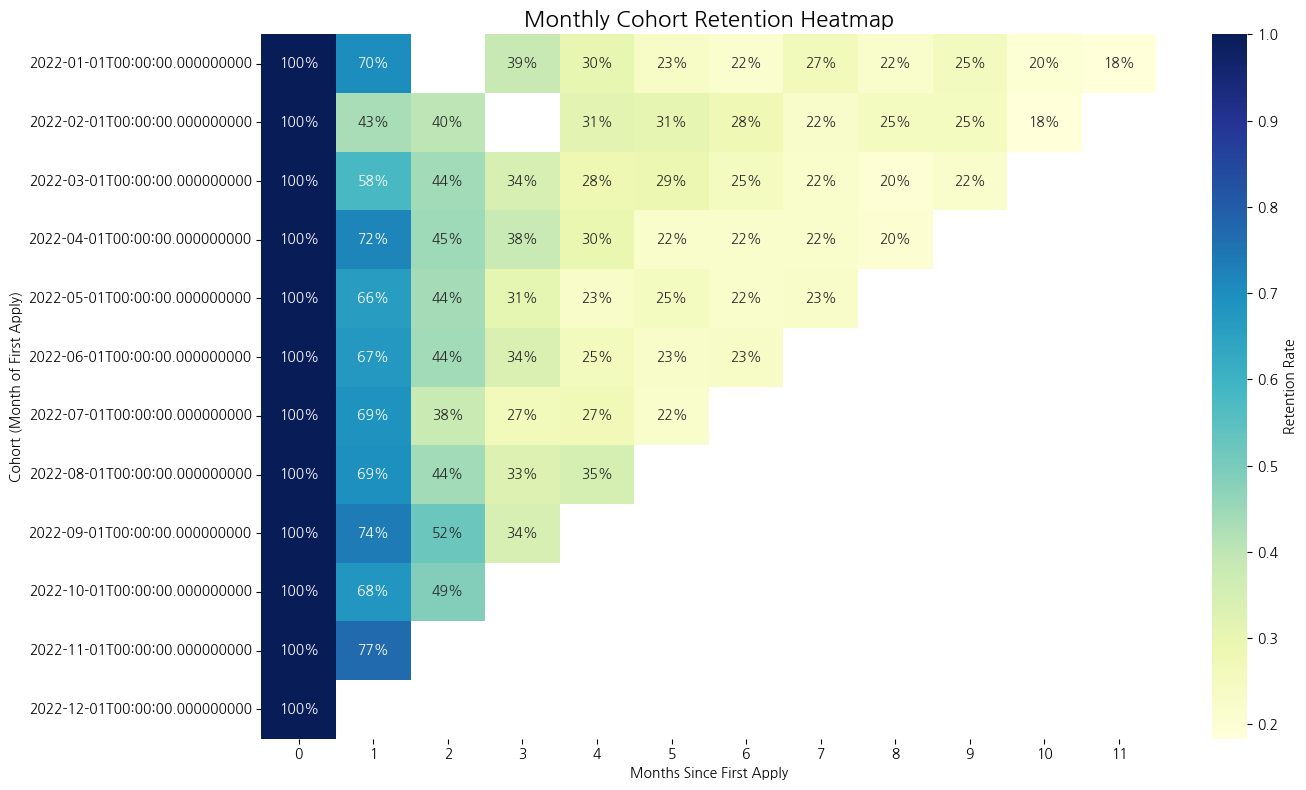

In [81]:
plt.figure(figsize=(14, 8))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate'})

plt.title("Monthly Cohort Retention Heatmap", fontsize=16)
plt.xlabel("Months Since First Apply")
plt.ylabel("Cohort (Month of First Apply)")
plt.tight_layout()
plt.show()

#### 1월 코호트 확인

In [82]:
# 1. timestamp 형식 정리
df = test_after_apply_df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 2. 최초 지원 시점 추출 (apply 로그만 필터링)
apply_logs = df[df["cleaned_url"] == "api/jobs/id/apply/step4"]
apply_logs["first_apply_month"] = apply_logs.groupby("user_uuid")["timestamp"].transform("min")
apply_logs["first_apply_month"] = apply_logs["first_apply_month"].dt.to_period("M")

# 3. 2023년 1월 코호트 유저 추출
jan_cohort_users = apply_logs[apply_logs["first_apply_month"] == "2022-01"]["user_uuid"].unique()

# 4. 전체 데이터 중, 이 유저들이 2023년 3월에 활동한 로그 필터링
march_activity = df[
    (df["user_uuid"].isin(jan_cohort_users)) &
    (df["timestamp"].dt.to_period("M") == "2022-03")
]

# 결과 확인
march_activity

<ipython-input-82-f8f361f487b5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apply_logs["first_apply_month"] = apply_logs.groupby("user_uuid")["timestamp"].transform("min")
<ipython-input-82-f8f361f487b5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apply_logs["first_apply_month"] = apply_logs["first_apply_month"].dt.to_period("M")


,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
935,8107468,00495153-f908-4523-9d0d-5b93a57196a4,continue?next=/@daba5054/applications&token=o0...,2022-03-01 02:50:16.998001,2022-03-01,302,GET,continue
936,8107610,00495153-f908-4523-9d0d-5b93a57196a4,@user_id/applications,2022-03-01 02:50:17.208813,2022-03-01,200,GET,@user_id/applications
937,8107559,00495153-f908-4523-9d0d-5b93a57196a4,continue?next=/@daba5054/applications&token=kf...,2022-03-03 01:18:51.312942,2022-03-03,302,GET,continue
938,8107910,00495153-f908-4523-9d0d-5b93a57196a4,@user_id/applications,2022-03-03 01:18:51.551674,2022-03-03,200,GET,@user_id/applications
939,8107797,00495153-f908-4523-9d0d-5b93a57196a4,search?keywords=캠핑,2022-03-04 02:41:41.221192,2022-03-04,200,GET,search
...,...,...,...,...,...,...,...,...
1072609,7803155,fbf5016a-c077-4a7c-89ad-3d99c754aae9,api/search/companies/company_id?name=환경,2022-03-13 07:24:39.136189,2022-03-13,200,GET,api/search/companies/company_id
1072610,7803068,fbf5016a-c077-4a7c-89ad-3d99c754aae9,api/jobs/job_title?page=&q=&tag=환경/재활용,2022-03-13 07:24:41.592767,2022-03-13,200,GET,api/jobs/job_title
1072611,7803199,fbf5016a-c077-4a7c-89ad-3d99c754aae9,api/search/companies/company_id?name=환경/재활용,2022-03-13 07:25:13.401176,2022-03-13,200,GET,api/search/companies/company_id
1072612,7803200,fbf5016a-c077-4a7c-89ad-3d99c754aae9,api/jobs/job_title?tag=환경/재활용&tag=환경,2022-03-13 07:25:17.629507,2022-03-13,200,GET,api/jobs/job_title


In [84]:
# 복사 후 전처리
df = test_after_apply_df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 분석할 유저
user_id = "fbf5016a-c077-4a7c-89ad-3d99c754aae9"

# 1. 해당 유저의 최초 지원일 (apply 로그만)
apply_logs = df[
    (df["user_uuid"] == user_id) &
    (df["cleaned_url"] == "api/jobs/id/apply/step4")
]
first_apply_date = apply_logs["timestamp"].min()

print("✅ 최초 지원일:", first_apply_date)

# 2. 해당 유저의 2023년 3월 활동 로그
march_logs = df[
    (df["user_uuid"] == user_id) &
    (df["timestamp"].dt.to_period("M") == pd.Period("2022-03"))
]

print("\n✅ 2022년 3월 활동 내역:")
print(march_logs[["timestamp", "cleaned_url"]].sort_values("timestamp"))

✅ 최초 지원일: 2022-01-26 06:20:59.564429

✅ 2022년 3월 활동 내역:
                         timestamp                      cleaned_url
1072606 2022-03-13 07:24:16.853471                              NaN
1072607 2022-03-13 07:24:22.239500                             jobs
1072608 2022-03-13 07:24:25.215758               api/jobs/job_title
1072609 2022-03-13 07:24:39.136189  api/search/companies/company_id
1072610 2022-03-13 07:24:41.592767               api/jobs/job_title
1072611 2022-03-13 07:25:13.401176  api/search/companies/company_id
1072612 2022-03-13 07:25:17.629507               api/jobs/job_title
1072613 2022-03-13 07:25:44.008915            @user_id/applications


In [85]:
retention_keywords = [
    "api/users/id/education",
    "api/users/id/career",
    "api/users/id/project",
    "api/users/id/image",
    "api/users/id/resume",
    "api/search/companies",
    "companies/company_id/jobs",
    "api/companies/id/view",
    "jobs/id",
    "jobs/id/apply",
    "api/users/id/sns",
    "api/users/id/profile_image/facebook",
    "api/verify/education/id"
]

# Retention URL로 분류
retention_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in retention_keywords)]

In [86]:
"api/search/companies/company_id" in retention_urls

True

# Acquisition 퍼널 분석

```python
cleaned_unique_urls = log_2023_df["cleaned_url"].unique()

acquisition_keywords = [
    "signup",
    "signup/step1",
    "signup/step2",
    "signup/step3",
    "api/signup",
    "email_verify",
    "verify_phone"
]

# Acquisition URL로 분류
acquisition_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in acquisition_keywords)]
```

- 퍼널 단계 구성
    - 방문 -> ... -> 회원가입 완료

In [87]:
len(log_2022_df["user_uuid"].unique())

17112

- 최초 방문자 어떻게 정의할 것인가?
    - 22년 이전 회원가입 한 인원은 어떻게 거를 것인가?

- application, bookmark 테이블 활용
    - application 테이블에 2022년도 필터링 -> 22년도에 지원 완료한 인원
        - 22년도에 가입 완료 되어 있는 사람 (가입 해야만 지원할 수 있기 때문)
            - 22년도에 가입 완료하고 바로 지원했을 수도 있음 -> 신규 회원임
            - 22년도 이전에 가입하고 22년도에 지원한 기록이 남아있을 경우 -> 신규 회원 아님

- application 테이블에서 unique를 찍고
- 2022년도로 필터링
    - 22년도에 가입한 사람일 수도 있고 22년 이전에 가입했는데 22년에 처음 지원한 사람일 수도 있음

- 22년도 필터링 한 사람들 A
- 로그데이터에서 확인한 22년도 Acquisition 인원들 B

- A - B = 22년 이전에 가입했는데 22년에 처음 지원한 사람이지 않겠냐?
- 그럼 A - B를 제외한 log_2022_df 유저들은
- 저희가 생각하는 2022년에 처음 방문 한 사람?

## 정의

- 2022년 로그에 있는 약 17000명 중
- 22년 이전에 가입 완료한 사람 제외
    - 그게 22년 신규 방문자

## 1차 필터링

In [88]:
application_df

,Unnamed: 0,cdate,company_uuid,job_uuid,user_uuid,application_uuid
0,0,2017-02-25 23:45:01.000000,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37,b0329bd7-fc45-4e83-993a-b73bd9d3549c,59c42363-f764-4cbd-aafd-20eb663ea5d7
1,1,2020-11-23 14:46:07.329731,f6156b12-d4d7-469f-84be-31799c765211,e5ed4f4a-08aa-4f2d-9042-1e9bbd36803f,b0329bd7-fc45-4e83-993a-b73bd9d3549c,425db0e8-87f8-4b4d-8248-7f24c31d49d3
2,2,2017-10-28 22:30:10.631568,2ed05b18-c735-474a-9faa-02095b25729a,0f636d7a-53f7-485e-8a08-33253ddab380,b0329bd7-fc45-4e83-993a-b73bd9d3549c,be4d9e85-dc53-4e70-90af-64d2d6b117d2
3,3,2017-07-03 17:40:05.317255,3d6730ee-b869-47b7-90c6-1e074e4eb15b,3cade56a-6354-411a-82a6-f2c7774539c1,b0329bd7-fc45-4e83-993a-b73bd9d3549c,d43879d1-c424-4192-9eae-4537fa6687cb
4,4,2017-02-10 10:53:39.000000,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37,a7593a15-b93e-4bc3-91bf-e4074c931d33,61873fd7-f075-44c0-90fe-f6521226550d
...,...,...,...,...,...,...
340725,340725,2021-05-09 16:48:46.908545,214c0ee9-4fc9-46be-ba8a-2a0368510e80,201fda38-4fbd-4541-aa27-c0a529e26c83,e5cb061e-3ca1-438a-8eb2-e50bd4f133e0,ecd4d247-8e03-4830-a4e8-c1ecb68ddf74
340726,340726,2022-03-20 22:21:29.175182,214c0ee9-4fc9-46be-ba8a-2a0368510e80,a82d7bd3-87ee-4eaf-9519-1b60a331a474,dc1fb548-59dd-47bc-82aa-99d92e70f793,0ab0adef-da09-4381-baf7-a3fb017c19ea
340727,340727,2022-04-07 09:41:05.036134,565e7499-1070-49c5-a3b9-a27e5ca27a9e,744ab632-8193-406a-bd51-3e2c9ddd4544,1e311075-359d-40fd-b606-f74cb1819499,bbd1050f-3729-45d9-8404-c8ad75dc5131
340728,340728,2022-07-15 04:22:09.138346,79d4e2b6-e8df-4605-9c2c-b00e73698b61,5faf63f9-848e-4286-a07c-992c0883115d,7ba43545-bf1c-465e-8996-e55231b020c6,43107da9-ff4d-4e62-9dd2-1b2df5a9ae78


In [89]:
# 2021년 이전 데이터 필터링
pre_2022_application_df = application_df[application_df['cdate'] < '2022-01-01']

In [90]:
pre_2022_application_df = pre_2022_application_df.sort_values(by='cdate')

In [91]:
pre_2022_application_df

,Unnamed: 0,cdate,company_uuid,job_uuid,user_uuid,application_uuid
47672,47672,2015-02-24 10:22:28.000000,90dbbb35-2ed6-4339-b011-a425ba62090a,c3078583-0258-4482-b08d-980e73fae123,6a6c3aea-6633-4121-a3d8-149acabfb797,8c24f8e5-238a-495e-a62e-9352e177a5b5
37644,37644,2015-03-02 16:29:22.000000,90dbbb35-2ed6-4339-b011-a425ba62090a,2e6d9a89-a542-4762-b7f5-8bed49202b04,2ece8d7d-79b6-4522-928b-8dbae8843fab,af0fa701-3d70-4533-9fb6-9376ee86b8ab
37645,37645,2015-03-02 22:36:11.000000,90dbbb35-2ed6-4339-b011-a425ba62090a,c3078583-0258-4482-b08d-980e73fae123,2ece8d7d-79b6-4522-928b-8dbae8843fab,8e0fb33f-7f73-4f28-9d78-47046f43699f
338939,338939,2015-03-03 08:47:08.000000,90dbbb35-2ed6-4339-b011-a425ba62090a,c3078583-0258-4482-b08d-980e73fae123,9e9fd179-bbfb-4595-9f06-d94b64af4e8a,b2086de3-f339-4b99-85e1-f77179d088b6
338937,338937,2015-03-03 22:56:40.000000,90dbbb35-2ed6-4339-b011-a425ba62090a,2e6d9a89-a542-4762-b7f5-8bed49202b04,f42f71c7-5407-4759-b1d9-b99a502e98f4,899e55fc-e8dc-43f1-807d-3cdcffaae4c4
...,...,...,...,...,...,...
317087,317087,2021-12-31 19:17:14.471281,892f65a9-e8f3-404c-957b-4f03885717c9,d3bda451-3a07-4965-908c-d24d4f6011a8,0ddc155e-4619-4a25-8168-a54a5a7fa7c4,7b408288-1d06-425c-9ec7-0c04c020e8ff
317084,317084,2021-12-31 19:25:26.128620,28e0c4f9-6c7e-4c03-a731-6bed577957c1,24243293-f2c2-46f9-a39a-f5b852b843fe,0ddc155e-4619-4a25-8168-a54a5a7fa7c4,a6ac9e6a-1611-408b-a72a-5283cf76a3dc
317092,317092,2021-12-31 19:29:28.283136,8b1b436f-58f8-48ca-a670-4d35e1f6cc83,95d089ba-4384-47ef-9da9-fae60d9d3b32,0ddc155e-4619-4a25-8168-a54a5a7fa7c4,c2280f85-0db9-46bf-8fff-bca00a80927a
317089,317089,2021-12-31 19:31:41.175578,82c9949f-06ab-43b4-90eb-7d1c2ac7368b,44a0e3f4-7b59-41fd-8cc0-81eb1001fd94,0ddc155e-4619-4a25-8168-a54a5a7fa7c4,ca7d05b8-75db-48c9-afb4-1a88d30894df


In [92]:
bookmark_path = "/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/데이터 분석 중급 프로젝트_1/원본 데이터/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/이전/JobBookmark.csv"
bookmark_df = pd.read_csv(bookmark_path)

In [93]:
bookmark_df['cdate'] = pd.to_datetime(bookmark_df['cdate'])

In [95]:
# 2021년 이전 데이터 필터링
pre_2022_bookmark_df = bookmark_df[bookmark_df['cdate'] < '2022-01-01']

In [96]:
pre_2022_bookmark_df = pre_2022_bookmark_df.sort_values(by='cdate')

In [97]:
pre_2022_bookmark_df

,Unnamed: 0,cdate,job_uuid,user_uuid
141099,141099,2015-09-25 06:15:22,db11c35b-ad4d-4170-80c3-2c722f120796,9e132912-5e19-4d93-a87c-4f20ef6c93f6
408246,408246,2015-09-25 08:01:45,375ba9b4-9e0f-420a-b72f-1d864c538124,2dea8a6b-3297-4883-911a-ae4a37d0ac06
405605,405605,2015-09-25 08:28:54,375ba9b4-9e0f-420a-b72f-1d864c538124,e03e6249-7243-4bac-8e28-9d7583bcf9a9
174342,174342,2015-09-25 10:53:23,fe90b3d8-c59b-40b5-b358-dfbbc916e37b,45b6373b-9bfd-40c1-8b49-6d1ceb51e156
174343,174343,2015-09-25 11:07:24,2204bafc-be7d-47d0-9e47-8380df33a2d7,45b6373b-9bfd-40c1-8b49-6d1ceb51e156
...,...,...,...,...
264010,264010,2021-12-31 21:29:06,d318f4a6-f34c-4d56-ac3b-5f68e12d8212,e4b85fc7-9dc9-4f67-bb0d-181eb88e16f3
44981,44981,2021-12-31 21:29:25,68740c0b-3e0e-47b4-a54e-703fc0a85cd1,1f8a5ced-a589-47f1-8dc3-feb29cd3eaf5
45021,45021,2021-12-31 21:29:37,22bc7574-7c87-47ad-b850-4984c0e8a894,1f8a5ced-a589-47f1-8dc3-feb29cd3eaf5
44974,44974,2021-12-31 21:29:42,e343f35d-3986-44cc-9e9d-3c99654308d9,1f8a5ced-a589-47f1-8dc3-feb29cd3eaf5


In [98]:
len(pre_2022_application_df["user_uuid"].unique())

28834

In [99]:
len(pre_2022_bookmark_df["user_uuid"].unique())

38988

In [100]:
pre_2022_application_df["user_uuid"]

,user_uuid
47672,6a6c3aea-6633-4121-a3d8-149acabfb797
37644,2ece8d7d-79b6-4522-928b-8dbae8843fab
37645,2ece8d7d-79b6-4522-928b-8dbae8843fab
338939,9e9fd179-bbfb-4595-9f06-d94b64af4e8a
338937,f42f71c7-5407-4759-b1d9-b99a502e98f4
...,...
317087,0ddc155e-4619-4a25-8168-a54a5a7fa7c4
317084,0ddc155e-4619-4a25-8168-a54a5a7fa7c4
317092,0ddc155e-4619-4a25-8168-a54a5a7fa7c4
317089,0ddc155e-4619-4a25-8168-a54a5a7fa7c4


In [101]:
pre_2022_bookmark_df["user_uuid"]

,user_uuid
141099,9e132912-5e19-4d93-a87c-4f20ef6c93f6
408246,2dea8a6b-3297-4883-911a-ae4a37d0ac06
405605,e03e6249-7243-4bac-8e28-9d7583bcf9a9
174342,45b6373b-9bfd-40c1-8b49-6d1ceb51e156
174343,45b6373b-9bfd-40c1-8b49-6d1ceb51e156
...,...
264010,e4b85fc7-9dc9-4f67-bb0d-181eb88e16f3
44981,1f8a5ced-a589-47f1-8dc3-feb29cd3eaf5
45021,1f8a5ced-a589-47f1-8dc3-feb29cd3eaf5
44974,1f8a5ced-a589-47f1-8dc3-feb29cd3eaf5


In [102]:
# user_uuid 시리즈 추출
application_users = pre_2022_application_df["user_uuid"]
bookmark_users = pre_2022_bookmark_df["user_uuid"]

# 두 시리즈를 합치고 중복 제거
pre_2022_members = pd.concat([application_users, bookmark_users]).drop_duplicates().reset_index(drop=True)

pre_2022_members

,user_uuid
0,6a6c3aea-6633-4121-a3d8-149acabfb797
1,2ece8d7d-79b6-4522-928b-8dbae8843fab
2,9e9fd179-bbfb-4595-9f06-d94b64af4e8a
3,f42f71c7-5407-4759-b1d9-b99a502e98f4
4,9a71095a-0703-4621-9671-8f381f285a26
...,...
53971,a489ad83-1f53-4688-885e-34e705117fd6
53972,ed4dd1e3-50af-4088-88ef-b52a4a070651
53973,b40b703c-2967-4d6e-9754-a3c916174f3f
53974,82e22b19-8c57-4946-91f4-b56f970c1e97


In [103]:
pre_2022_members.unique()

array(['6a6c3aea-6633-4121-a3d8-149acabfb797',
       '2ece8d7d-79b6-4522-928b-8dbae8843fab',
       '9e9fd179-bbfb-4595-9f06-d94b64af4e8a', ...,
       'b40b703c-2967-4d6e-9754-a3c916174f3f',
       '82e22b19-8c57-4946-91f4-b56f970c1e97',
       'e4b85fc7-9dc9-4f67-bb0d-181eb88e16f3'], dtype=object)

In [104]:
log_2022_df["user_uuid"].unique()

array(['8a7e70cd-1630-4a8a-8303-0706af3a7908',
       '207a8876-2a6c-4137-9347-476ce719c541',
       'd7c84302-545f-4714-bcd1-0cc4328a0f89', ...,
       'f9387b22-2d7d-4267-8671-2279e2d784b9',
       '849ff1bb-6280-46f4-baaa-71d1d0796b5b',
       '940b883f-a385-416c-94e2-b5604a78506c'], dtype=object)

In [105]:
# 먼저 pre_2022_members를 set으로 변환 (빠른 검색을 위해)
pre_2022_member_set = set(pre_2022_members.unique())

# log_2022_df에서 user_uuid가 pre_2022_members에 없는 값만 필터링
filtered_uuids = [uuid for uuid in log_2022_df["user_uuid"].unique() if uuid not in pre_2022_member_set]

# 결과를 Series로 저장
first_filtered_members = pd.Series(filtered_uuids, name="user_uuid")

- first_filtered_members = 2022 로그 데이터 중 22년 이전 지원 혹은 북마크를 한 유저 제외한 유저

In [106]:
len(first_filtered_members.unique())

4755

In [107]:
len(acquisition_logs["user_uuid"].unique())

4734

In [108]:
acquisition_logs["user_uuid"].unique()

array(['8a7e70cd-1630-4a8a-8303-0706af3a7908',
       '207a8876-2a6c-4137-9347-476ce719c541',
       '7e92fb11-d00d-4db4-8574-bbba6355be6c', ...,
       '900f49df-4432-40f1-b049-d502b86010e2',
       '3f05dcb8-3227-4ba6-b258-ae57016073f6',
       'e122966e-02f3-4d2a-a0a5-810a37c2c69f'], dtype=object)

In [109]:
# acquisition_logs의 user_uuid들을 set으로 변환
acquisition_user_set = set(acquisition_logs["user_uuid"].unique())

# first_filtered_members에서 acquisition_logs에 없는 UUID만 남기기
after_filter_uuids = [uuid for uuid in first_filtered_members.unique() if uuid not in acquisition_user_set]

# Series로 저장
after_first_filter = pd.Series(after_filter_uuids, name="user_uuid")

In [111]:
len(log_2022_df["user_uuid"].unique())

17112

- log_2022_df 전체 유저 수 17,112명
- application, bookmark 테이블에서 확인한 22년 이전에 회원가입 완료한 유저 제외한 유저 수 (신규 방문자 수) 4,755명
- acquisition_logs["user_uuid"].unique() 22년에 회원가입 시도한 유저 수 4,734명

- 22년 신규 방문자에서 신규 회원가입 시도한 유저 뺐더니? 1,405명?

- 반대로 말하면? 22년도 로그데이터가 있는 17,112명 중 약 13,000명이 기존 유저라는 얘기

## 분석 기준 재정립!

- 신규 방문자 정의에서 너무 많은 오류가 있는 것 같음
    - application, bookmark 테이블에 연동되는 데이터가
    - 로그에서 확인할 수 있는 데이터와 뭔가 다르다고 판단

- 신규 방문자를 정의하기 보단 획득 단계에서 이탈률을 줄여 획득률을 높이는 방향으로 다시 시작
    - 기존 4,734명을 시작으로 회원가입 완료까지 가는 과정에서 이탈하는 비율을 확인하고
    - 특히 이탈을 많이 하는 지점이 있다면 그 이유도 유추

- 퍼널 단계
    - signup/detail
    - signup/step1
    - signup/step2
    - signup/step3

### 퍼널 분석

In [121]:
# clean_url 만들기
acquisition_logs["clean_url"] = acquisition_logs["cleaned_url"].str.lower()

# 퍼널 단계 정의
funnel_stages = {
    "detail": ["detail"],
    "step1": ["signup/step1"],
    "step2": ["signup/step2"],
    "step3": ["signup/step3"],
}

# 퍼널 단계 부여 함수
def assign_funnel_stage(url):
    url = str(url).lower()
    for stage, keywords in funnel_stages.items():
        if any(k in url for k in keywords):
            return stage
    return "other"

# funnel_stage 컬럼 생성
acquisition_logs["funnel_stage"] = acquisition_logs["clean_url"].apply(assign_funnel_stage)

acquisition_logs.head()

<ipython-input-121-20e7712414be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acquisition_logs["clean_url"] = acquisition_logs["cleaned_url"].str.lower()
<ipython-input-121-20e7712414be>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acquisition_logs["funnel_stage"] = acquisition_logs["clean_url"].apply(assign_funnel_stage)


,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
1,1,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/signup/form,2022-06-22 16:19:07.770741,2022-06-23,200,POST,api/signup/form,api/signup/form,other
38,38,8a7e70cd-1630-4a8a-8303-0706af3a7908,signup/step2/education,2022-06-22 16:19:49.939376,2022-06-23,200,GET,signup/step2/education,signup/step2/education,step2
39,39,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/signup/form,2022-06-22 16:19:07.253808,2022-06-23,200,POST,api/signup/form,api/signup/form,other
53,53,8a7e70cd-1630-4a8a-8303-0706af3a7908,signup/step3/done,2022-06-22 16:20:49.307512,2022-06-23,200,GET,signup/step3/done,signup/step3/done,step3
81,81,8a7e70cd-1630-4a8a-8303-0706af3a7908,signup/step2/career,2022-06-22 16:18:52.396236,2022-06-23,200,GET,signup/step2/career,signup/step2/career,step2


#### detail -> step1

In [123]:
detail_stage = acquisition_logs[acquisition_logs["funnel_stage"] == "detail"]
detail_members = detail_stage["user_uuid"].unique()
len(detail_members)

3987

In [124]:
detail_df = acquisition_logs[acquisition_logs['user_uuid'].isin(detail_members)].reset_index(drop=True)

In [126]:
# detail -> step1
step_1_stage = detail_df[detail_df["funnel_stage"] == "step1"]
step_1_stage

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
5,93,8a7e70cd-1630-4a8a-8303-0706af3a7908,signup/step1/name,2022-06-22 16:18:45.831398,2022-06-23,200,GET,signup/step1/name,signup/step1/name,step1
11,284,207a8876-2a6c-4137-9347-476ce719c541,signup/step1/name,2022-06-12 16:48:33.325609,2022-06-13,200,GET,signup/step1/name,signup/step1/name,step1
15,11913,7e92fb11-d00d-4db4-8574-bbba6355be6c,signup/step1/verify,2022-06-12 06:23:05.214476,2022-06-12,200,GET,signup/step1/verify,signup/step1/verify,step1
18,11957,7e92fb11-d00d-4db4-8574-bbba6355be6c,signup/step1/verify,2022-06-12 06:22:56.272819,2022-06-12,200,GET,signup/step1/verify,signup/step1/verify,step1
19,12165,7e92fb11-d00d-4db4-8574-bbba6355be6c,signup/step1/verify,2022-06-12 06:23:10.136491,2022-06-12,302,GET,signup/step1/verify,signup/step1/verify,step1
...,...,...,...,...,...,...,...,...,...,...
37488,10053492,900f49df-4432-40f1-b049-d502b86010e2,signup/step1/name,2022-05-17 17:29:30.818682,2022-05-18,200,GET,signup/step1/name,signup/step1/name,step1
37492,10053499,900f49df-4432-40f1-b049-d502b86010e2,signup/step1/name,2022-05-17 17:29:34.724280,2022-05-18,200,GET,signup/step1/name,signup/step1/name,step1
37493,10053500,900f49df-4432-40f1-b049-d502b86010e2,signup/step1/name,2022-05-17 17:29:17.035442,2022-05-18,200,GET,signup/step1/name,signup/step1/name,step1
37494,10053537,3f05dcb8-3227-4ba6-b258-ae57016073f6,signup/step1/name,2022-11-13 11:49:54.576757,2022-11-13,200,GET,signup/step1/name,signup/step1/name,step1


In [128]:
len(step_1_stage["user_uuid"].unique())

3935

#### detail -> step1

In [129]:
step_1_stage = detail_df[detail_df["funnel_stage"] == "step1"]
step_1_members = step_1_stage["user_uuid"].unique()
len(step_1_members)

3935

#### step1 -> step2

In [130]:
step_1_df = detail_df[detail_df['user_uuid'].isin(step_1_members)].reset_index(drop=True)

# step1 -> step2
step_2_stage = step_1_df[step_1_df["funnel_stage"] == "step2"]
step_2_members = step_2_stage["user_uuid"].unique()
len(step_2_stage["user_uuid"].unique())

3407

#### step2 -> step3

In [131]:
step_2_df = step_1_df[step_1_df['user_uuid'].isin(step_2_members)].reset_index(drop=True)

# step2 -> step3
step_3_stage = step_2_df[step_2_df["funnel_stage"] == "step3"]
step_3_members = step_3_stage["user_uuid"].unique()
len(step_3_stage["user_uuid"].unique())

2799

#### step3 -> done

In [132]:
step_3_df = step_2_df[step_2_df['user_uuid'].isin(step_3_members)].reset_index(drop=True)
done_df = step_3_df[step_3_df["cleaned_url"] == "signup/step3/done"]
len(done_df["user_uuid"].unique())

2718

#### 정리

In [134]:
detail_number = len(detail_members)
step_1_number = len(step_1_members)
step_2_number = len(step_2_members)
step_3_number = len(step_3_members)
done_number = len(done_df["user_uuid"].unique())

In [135]:
# 단계별 유입자 수
stage_names = ["상세 페이지 진입", "1단계", "2단계", "3단계", "완료"]
counts = [detail_number, step_1_number, step_2_number, step_3_number, done_number]

# 기준이 되는 상세 페이지 진입 수
base_number = counts[0]

# 백분율 계산: 각 단계의 유입자 수 / 상세 페이지 진입 수 * 100
percentage_rates = [round((count / base_number) * 100, 2) for count in counts]

# 이탈률 계산
dropoff_rates = []
for i in range(len(counts) - 1):
    rate = (counts[i] - counts[i+1]) / counts[i]
    dropoff_rates.append(round(rate * 100, 2))
dropoff_rates.append(0.0)  # 완료 단계에서는 이탈률 없음

# 표 생성
df = pd.DataFrame({
    "단계": stage_names,
    "유입자 수": counts,
    "이탈률 (%)": dropoff_rates,
    "백분율 (%)": percentage_rates
})

df

,단계,유입자 수,이탈률 (%),백분율 (%)
0,상세 페이지 진입,3987,1.30,100.00
1,1단계,3935,13.42,98.70
2,2단계,3407,17.85,85.45
3,3단계,2799,2.89,70.20
4,완료,2718,0.00,68.17


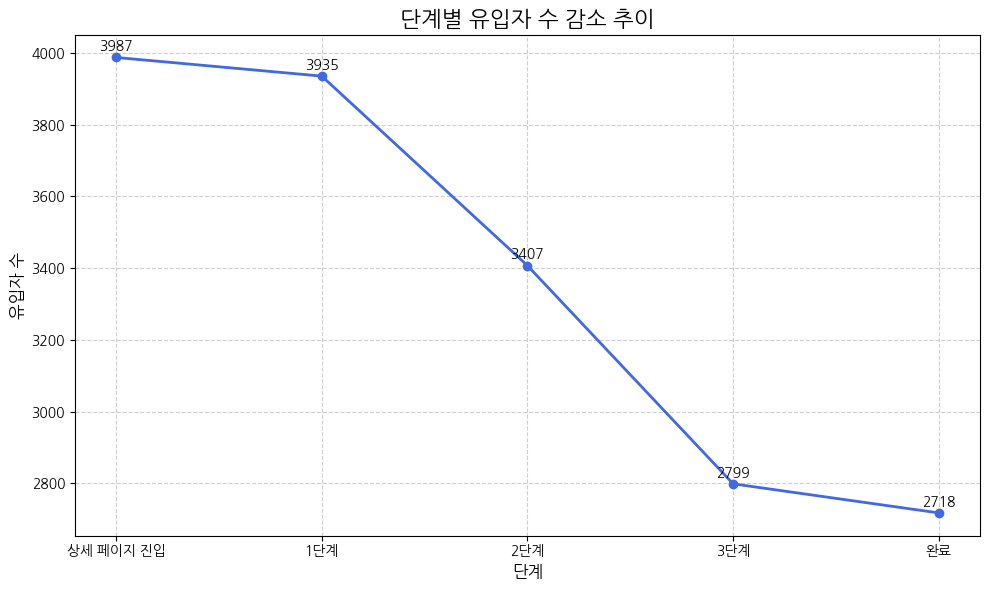

In [136]:
# 단계 이름과 유입자 수 (너의 실제 값으로 바꿔줘)
stage_names = ["상세 페이지 진입", "1단계", "2단계", "3단계", "완료"]
counts = [detail_number, step_1_number, step_2_number, step_3_number, done_number]

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(stage_names, counts, marker='o', linestyle='-', color='royalblue', linewidth=2)
plt.title("단계별 유입자 수 감소 추이", fontsize=16)
plt.xlabel("단계", fontsize=12)
plt.ylabel("유입자 수", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 각 점에 유입자 수 표시
for i, count in enumerate(counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### 세부 퍼널 분석

#### 퍼널 경로 시각화 해보기

In [137]:
funnel_order = ["detail", "step1", "step2", "step3"]

# 유저별로 funnel_stage 시퀀스 추출
user_funnels = (
    detail_df[detail_df["funnel_stage"].isin(funnel_order)]
    .sort_values(["user_uuid", "timestamp"])
    .groupby("user_uuid")["funnel_stage"]
    .apply(list)
)

In [138]:
from collections import Counter

# 각 유저의 시퀀스를 (이전단계, 다음단계) 쌍으로 변환
transition_pairs = []

for seq in user_funnels:
    for i in range(len(seq) - 1):
        transition_pairs.append((seq[i], seq[i + 1]))

# 전환 쌍 빈도수 계산
transition_counts = Counter(transition_pairs)

#### detail -> step1 에서 step2, 3 제거하기

In [141]:
detail_df = detail_df.sort_values(by=["user_uuid", "timestamp"])
detail_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
20904,8681713,0017a738-4fcc-441e-983b-a6033890a9db,signup/detail,2022-04-08 11:52:14.152848,2022-04-08,302,GET,signup/detail,signup/detail,detail
20903,8681536,0017a738-4fcc-441e-983b-a6033890a9db,signup/step1/name,2022-04-08 11:52:14.254505,2022-04-08,200,GET,signup/step1/name,signup/step1/name,step1
20901,8681355,0017a738-4fcc-441e-983b-a6033890a9db,signup/step2/career,2022-04-08 11:53:01.227766,2022-04-08,200,GET,signup/step2/career,signup/step2/career,step2
20907,8681849,0017a738-4fcc-441e-983b-a6033890a9db,signup/step2/education,2022-04-08 11:54:26.301939,2022-04-08,200,GET,signup/step2/education,signup/step2/education,step2
20906,8681812,0017a738-4fcc-441e-983b-a6033890a9db,signup/step3/import,2022-04-08 11:54:56.396017,2022-04-08,200,GET,signup/step3/import,signup/step3/import,step3
...,...,...,...,...,...,...,...,...,...,...
18789,8311200,fff45252-3c40-4805-99e9-6b650c1fca80,signup/step3/discover,2022-12-27 01:05:28.504923,2022-12-27,200,GET,signup/step3/discover,signup/step3/discover,step3
18797,8311223,fff45252-3c40-4805-99e9-6b650c1fca80,signup/step3/done,2022-12-27 01:08:24.808972,2022-12-27,200,GET,signup/step3/done,signup/step3/done,step3
30196,9730982,fff8a5c0-c85b-4e30-a22d-ed61b4480615,signup/detail,2022-03-23 11:57:34.460373,2022-03-23,302,GET,signup/detail,signup/detail,detail
30194,9730847,fff8a5c0-c85b-4e30-a22d-ed61b4480615,signup/step1/name,2022-03-23 11:57:34.579381,2022-03-23,200,GET,signup/step1/name,signup/step1/name,step1


##### detail로 시작하는 애들만 추출 (started_with_detail_df)

In [142]:
# 유저별로 가장 첫 row 추출
first_stage_df = detail_df.groupby("user_uuid").first().reset_index()

# funnel_stage가 "detail"이 아닌 유저만 필터링
not_started_detail_uuids = first_stage_df[first_stage_df["funnel_stage"] != "detail"]["user_uuid"]

# 해당 유저들의 전체 로그를 원하면 다음처럼 필터링
not_started_detail = detail_df[detail_df["user_uuid"].isin(not_started_detail_uuids)]

In [143]:
not_started_detail["user_uuid"].nunique()

55

In [144]:
# detail로 시작하는 친구들
started_with_detail_df = detail_df[~detail_df["user_uuid"].isin(not_started_detail_uuids)]

In [146]:
started_with_detail_df["user_uuid"].nunique()

3932

In [147]:
started_with_detail_df["funnel_stage"].unique()

array(['detail', 'step1', 'step2', 'step3', 'other'], dtype=object)

##### detail로 시작해서 done 까지 간 애들

In [148]:
started_to_done_df = acquisition_logs[acquisition_logs["cleaned_url"] == "signup/step3/done"]

In [149]:
started_to_done_df["user_uuid"].nunique()

2762

- detail에서 step1, step2, step3까지 간 후 done에 도달한 사람은 2718명이 나왔는데
    - detail에서 step1, step2, step3 (and의 개념)
- 회원가입 시도한 사람들 중 done까지 도달한 사람은 2762명
    - 추가된 44명은 detail, step1, 2, 3 중 하나라도 포함되지 않을 수 있는 사람들
        - 모든 과정을 거치지 않고 회원가입을 완료한 사람이 44명

##### started_with_detail_df에서 step1 이전에 step2, 3 나온 애들 추출

In [150]:
# 유저별로 index를 보존한 상태에서 그룹화
grouped = started_with_detail_df.groupby("user_uuid")

# step1이 최초로 등장한 인덱스를 찾음
first_step1_idx = grouped.apply(lambda g: g[g["funnel_stage"] == "step1"].head(1).index[0] if not g[g["funnel_stage"] == "step1"].empty else None)

# step1이 존재하는 유저만 필터링
first_step1_idx = first_step1_idx.dropna()

# step1 이전에 step2 또는 step3이 있는 유저 찾기
violating_users = []

for user_uuid, idx in first_step1_idx.items():
    user_logs = started_with_detail_df[started_with_detail_df["user_uuid"] == user_uuid]
    logs_before_step1 = user_logs.loc[user_logs.index < idx]
    if logs_before_step1["funnel_stage"].isin(["step2", "step3"]).any():
        violating_users.append(user_uuid)

# 해당 유저들의 전체 로그 추출
step2and3_before_step1 = started_with_detail_df[started_with_detail_df["user_uuid"].isin(violating_users)]

<ipython-input-150-f9f21b9feab4>:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [152]:
step2and3_before_step1["user_uuid"].nunique()

2742

#### step1 -> step2 에서 step3 제거하기

In [153]:
step_1_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
0,1,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/signup/form,2022-06-22 16:19:07.770741,2022-06-23,200,POST,api/signup/form,api/signup/form,other
1,38,8a7e70cd-1630-4a8a-8303-0706af3a7908,signup/step2/education,2022-06-22 16:19:49.939376,2022-06-23,200,GET,signup/step2/education,signup/step2/education,step2
2,39,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/signup/form,2022-06-22 16:19:07.253808,2022-06-23,200,POST,api/signup/form,api/signup/form,other
3,53,8a7e70cd-1630-4a8a-8303-0706af3a7908,signup/step3/done,2022-06-22 16:20:49.307512,2022-06-23,200,GET,signup/step3/done,signup/step3/done,step3
4,81,8a7e70cd-1630-4a8a-8303-0706af3a7908,signup/step2/career,2022-06-22 16:18:52.396236,2022-06-23,200,GET,signup/step2/career,signup/step2/career,step2
...,...,...,...,...,...,...,...,...,...,...
37223,10053500,900f49df-4432-40f1-b049-d502b86010e2,signup/step1/name,2022-05-17 17:29:17.035442,2022-05-18,200,GET,signup/step1/name,signup/step1/name,step1
37224,10053537,3f05dcb8-3227-4ba6-b258-ae57016073f6,signup/step1/name,2022-11-13 11:49:54.576757,2022-11-13,200,GET,signup/step1/name,signup/step1/name,step1
37225,10053538,3f05dcb8-3227-4ba6-b258-ae57016073f6,signup/detail,2022-11-13 11:49:54.472945,2022-11-13,302,GET,signup/detail,signup/detail,detail
37226,10054007,e122966e-02f3-4d2a-a0a5-810a37c2c69f,signup/step1/name,2022-02-28 14:41:23.590382,2022-02-28,200,GET,signup/step1/name,signup/step1/name,step1


#### step2에 도달하지 않고 step3에 도달한 친구들

In [154]:
# step2를 방문한 적 있는 user_uuid들
has_step2 = step_1_df[step_1_df["cleaned_url"].str.contains("signup/step2")]["user_uuid"].unique()

# step3를 방문한 적 있는 user_uuid들
has_step3 = step_1_df[step_1_df["cleaned_url"].str.contains("signup/step3")]["user_uuid"].unique()

# step3는 있고 step2는 없는 user_uuid들만 선택
target_uuids = [uuid for uuid in has_step3 if uuid not in has_step2]

# 이 user_uuid들이 포함된 모든 기록
step_1_not_2_but_3 = step_1_df[step_1_df["user_uuid"].isin(target_uuids)]

step_1_not_2_but_3

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
483,461754,8b9da938-5fe2-4f1c-b86c-283a3b04417a,signup/step1/verify,2022-06-01 13:27:02.661514,2022-06-01,200,GET,signup/step1/verify,signup/step1/verify,step1
484,461773,8b9da938-5fe2-4f1c-b86c-283a3b04417a,signup/step3/discover,2022-06-04 03:19:00.584523,2022-06-04,200,GET,signup/step3/discover,signup/step3/discover,step3
485,461970,8b9da938-5fe2-4f1c-b86c-283a3b04417a,signup/step1/verify,2022-06-01 13:26:13.736682,2022-06-01,200,GET,signup/step1/verify,signup/step1/verify,step1
486,461973,8b9da938-5fe2-4f1c-b86c-283a3b04417a,signup/step1/verify,2022-06-01 13:26:46.770368,2022-06-01,200,GET,signup/step1/verify,signup/step1/verify,step1
487,461976,8b9da938-5fe2-4f1c-b86c-283a3b04417a,signup/step3/discover,2022-06-01 13:27:21.101745,2022-06-01,200,GET,signup/step3/discover,signup/step3/discover,step3
...,...,...,...,...,...,...,...,...,...,...
36530,10030427,70adfe57-d60b-4f7c-ac0b-414486755a7f,signup/step1/verify,2022-12-28 12:56:22.072588,2022-12-28,200,GET,signup/step1/verify,signup/step1/verify,step1
36531,10030433,70adfe57-d60b-4f7c-ac0b-414486755a7f,signup/detail,2022-12-28 12:56:05.920828,2022-12-28,302,GET,signup/detail,signup/detail,detail
36532,10030434,70adfe57-d60b-4f7c-ac0b-414486755a7f,signup/step3/discover,2022-12-28 12:56:25.308487,2022-12-28,200,GET,signup/step3/discover,signup/step3/discover,step3
36533,10030439,70adfe57-d60b-4f7c-ac0b-414486755a7f,signup/step1/verify,2022-12-28 12:56:18.902662,2022-12-28,200,GET,signup/step1/verify,signup/step1/verify,step1


In [155]:
len(step_1_not_2_but_3["user_uuid"].unique())

30

#### 이상한 애들 제외

In [156]:
# 제외할 user_uuid 목록
exclude_uuids = step_1_not_2_but_3["user_uuid"].unique()

# 해당 user_uuid를 제외한 행만 남기기
step_1_df = step_1_df[~step_1_df["user_uuid"].isin(exclude_uuids)]

In [157]:
step_1_df["user_uuid"].isin(exclude_uuids).sum()

np.int64(0)

#### step1에서 step2까지 도달하기 위한 경로 확인

In [158]:
# 1. timestamp 기준 정렬
step_1_df = step_1_df.sort_values('timestamp')

# 2. 함수 정의
def filter_step1_to_step2(df):
    result = []
    for user_id, group in df.groupby('user_uuid'):
        group = group.sort_values('timestamp')

        # step1 포함된 첫 row 찾기
        step1_idx = group[group['cleaned_url'].str.contains('signup/step1', na=False)].head(1).index
        if len(step1_idx) == 0:
            continue  # step1이 없으면 skip
        group = group.loc[step1_idx[0]:]

        # step2 포함된 첫 row 찾기
        step2_idx = group[group['cleaned_url'].str.contains('signup/step2', na=False)].head(1).index
        if len(step2_idx) == 0:
            continue  # step2가 없으면 skip
        group = group.loc[:step2_idx[0]]

        result.append(group)

    return pd.concat(result)

# 3. 필터링 실행
step_1_to_2_df = filter_step1_to_step2(step_1_df)

step_1_to_2_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
20725,8681536,0017a738-4fcc-441e-983b-a6033890a9db,signup/step1/name,2022-04-08 11:52:14.254505,2022-04-08,200,GET,signup/step1/name,signup/step1/name,step1
20723,8681355,0017a738-4fcc-441e-983b-a6033890a9db,signup/step2/career,2022-04-08 11:53:01.227766,2022-04-08,200,GET,signup/step2/career,signup/step2/career,step2
23032,9001154,007f87f4-adf8-45be-a6be-8f7121f1cbaf,signup/step1/name,2022-02-07 02:56:51.879007,2022-02-07,200,GET,signup/step1/name,signup/step1/name,step1
23037,9001522,007f87f4-adf8-45be-a6be-8f7121f1cbaf,signup/step2/career,2022-02-07 02:59:23.960789,2022-02-07,200,GET,signup/step2/career,signup/step2/career,step2
25396,9300941,008314c3-4837-40fc-be5a-b38d1072db30,signup/step1/name,2022-08-01 13:37:19.945899,2022-08-01,200,GET,signup/step1/name,signup/step1/name,step1
...,...,...,...,...,...,...,...,...,...,...
18613,8311184,fff45252-3c40-4805-99e9-6b650c1fca80,signup/step1/verify?next_url=/signup/detail,2022-12-27 01:01:32.050188,2022-12-27,200,GET,signup/step1/verify,signup/step1/verify,step1
18624,8311216,fff45252-3c40-4805-99e9-6b650c1fca80,signup/detail,2022-12-27 01:01:34.187687,2022-12-27,302,GET,signup/detail,signup/detail,detail
18619,8311201,fff45252-3c40-4805-99e9-6b650c1fca80,signup/step2/career,2022-12-27 01:01:34.408150,2022-12-27,200,GET,signup/step2/career,signup/step2/career,step2
29947,9730847,fff8a5c0-c85b-4e30-a22d-ed61b4480615,signup/step1/name,2022-03-23 11:57:34.579381,2022-03-23,200,GET,signup/step1/name,signup/step1/name,step1


#### step3를 가지는 행만 골라서 비교

- why_3 = step1 과 step2 사이에 step3가 있는 애들

In [160]:
why_3 = step_1_to_2_df[step_1_to_2_df["cleaned_url"].str.contains('signup/step3', na=False)]
why_3

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
19560,8454464,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step3/discover,2022-01-17 00:32:03.102233,2022-01-17,200,GET,signup/step3/discover,signup/step3/discover,step3
3194,2542021,10f0b4a1-d745-4a55-a48f-7bb701dd57c7,signup/step3/discover,2022-06-09 06:07:15.627359,2022-06-09,200,GET,signup/step3/discover,signup/step3/discover,step3
19342,8407548,142a94d1-9c14-4b85-908d-2d4c5ad49b51,signup/step3/discover,2022-12-12 10:59:59.594592,2022-12-12,200,GET,signup/step3/discover,signup/step3/discover,step3
31699,9832960,169ad669-a329-4940-b3e5-9fef0b209563,signup/step3/discover,2022-05-19 11:29:47.923239,2022-05-19,200,GET,signup/step3/discover,signup/step3/discover,step3
9495,5882280,1b0fe959-f4a1-4eb9-8fa2-370c90b67845,signup/step3/discover,2022-05-09 05:11:08.023197,2022-05-09,200,GET,signup/step3/discover,signup/step3/discover,step3
2397,2049371,2b8bbbd2-1089-4a02-a356-ab2f686b8226,signup/step3/discover,2022-08-05 08:58:11.164536,2022-08-05,200,GET,signup/step3/discover,signup/step3/discover,step3
810,665278,4f4cc114-c11a-4ae1-b991-f8d27ed23888,signup/step3/discover,2022-06-08 10:11:33.977744,2022-06-08,200,GET,signup/step3/discover,signup/step3/discover,step3
1099,1251954,503b14c6-f3d3-49f3-b3dc-fecb9121ae37,signup/step3/discover,2022-08-17 03:39:27.342829,2022-08-17,200,GET,signup/step3/discover,signup/step3/discover,step3
2290,1985383,59a8d03c-08b8-46bd-abd2-294b4cc842ed,signup/step3/discover,2022-06-12 07:06:57.222080,2022-06-12,200,GET,signup/step3/discover,signup/step3/discover,step3
2812,2271307,6f81e488-63b8-4448-bc14-ea8b4b32895e,signup/step3/discover,2022-06-11 17:12:57.729795,2022-06-12,200,GET,signup/step3/discover,signup/step3/discover,step3


In [161]:
# 제외할 user_uuid 목록
exclude_why_3_uuids = why_3["user_uuid"].unique()

# 해당 user_uuid를 제외한 행만 남기기
why_3_df = step_1_to_2_df[step_1_to_2_df["user_uuid"].isin(exclude_why_3_uuids)]

- exclude_why_3_uuids = why_3의 고유 유저 목록
- why_3_df = 1에서 2로 가는 사이에 3가 있는 애들만 모아놓은 데이터 프레임

In [162]:
why_3_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
19566,8454512,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step1/verify,2022-01-17 00:31:31.666445,2022-01-17,200,GET,signup/step1/verify,signup/step1/verify,step1
19563,8454481,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step1/verify,2022-01-17 00:31:36.346899,2022-01-17,200,GET,signup/step1/verify,signup/step1/verify,step1
19567,8454513,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step1/verify,2022-01-17 00:31:40.895072,2022-01-17,200,GET,signup/step1/verify,signup/step1/verify,step1
19556,8454432,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step1/verify,2022-01-17 00:31:45.993397,2022-01-17,200,GET,signup/step1/verify,signup/step1/verify,step1
19550,8454376,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step1/verify,2022-01-17 00:31:50.915862,2022-01-17,200,GET,signup/step1/verify,signup/step1/verify,step1
...,...,...,...,...,...,...,...,...,...,...
18185,8252092,fee3908f-7d48-4b5f-b637-5398166316d1,signup/step1/verify,2022-01-12 01:55:51.073303,2022-01-12,200,GET,signup/step1/verify,signup/step1/verify,step1
18181,8252052,fee3908f-7d48-4b5f-b637-5398166316d1,signup/step1/verify,2022-01-12 01:55:55.036789,2022-01-12,302,GET,signup/step1/verify,signup/step1/verify,step1
18195,8252318,fee3908f-7d48-4b5f-b637-5398166316d1,signup/detail,2022-01-12 01:55:55.069463,2022-01-12,302,GET,signup/detail,signup/detail,detail
18189,8252182,fee3908f-7d48-4b5f-b637-5398166316d1,signup/step3/discover,2022-01-12 01:55:55.202679,2022-01-12,200,GET,signup/step3/discover,signup/step3/discover,step3


In [164]:
# "signup/step2"가 포함된 행의 개수 세기
step2_count = why_3_df["cleaned_url"].str.contains("signup/step2", na=False).sum()

print("signup/step2가 포함된 행의 개수:", step2_count)

signup/step2가 포함된 행의 개수: 24


- 유저별 시간 역순

In [167]:
# timestamp를 datetime으로 변환 (이미 되어 있다면 생략 가능)
why_3_df["timestamp"] = pd.to_datetime(why_3_df["timestamp"])

# user_uuid별로 그룹화한 후, 각 그룹을 시간 역순으로 정렬
why_3_sorted = (
    why_3_df
    .sort_values(by=["user_uuid", "timestamp"], ascending=[True, False])
)

why_3_sorted

<ipython-input-167-0f010e518d7b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
19557,8454445,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step2/career,2022-01-17 00:32:04.106679,2022-01-17,200,GET,signup/step2/career,signup/step2/career,step2
19560,8454464,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step3/discover,2022-01-17 00:32:03.102233,2022-01-17,200,GET,signup/step3/discover,signup/step3/discover,step3
19562,8454470,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step1/verify,2022-01-17 00:32:02.834363,2022-01-17,302,GET,signup/step1/verify,signup/step1/verify,step1
19564,8454503,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/detail,2022-01-17 00:32:02.742982,2022-01-17,302,GET,signup/detail,signup/detail,detail
19553,8454394,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step1/verify,2022-01-17 00:31:58.887122,2022-01-17,200,GET,signup/step1/verify,signup/step1/verify,step1
...,...,...,...,...,...,...,...,...,...,...
18188,8252162,fee3908f-7d48-4b5f-b637-5398166316d1,signup/step1/verify,2022-01-12 01:55:33.527204,2022-01-12,200,GET,signup/step1/verify,signup/step1/verify,step1
18180,8252039,fee3908f-7d48-4b5f-b637-5398166316d1,signup/step1/verify,2022-01-12 01:55:30.255183,2022-01-12,200,GET,signup/step1/verify,signup/step1/verify,step1
18191,8252191,fee3908f-7d48-4b5f-b637-5398166316d1,signup/step1/verify,2022-01-12 01:55:26.148065,2022-01-12,200,GET,signup/step1/verify,signup/step1/verify,step1
18178,8252026,fee3908f-7d48-4b5f-b637-5398166316d1,signup/step1/verify,2022-01-12 01:55:22.183180,2022-01-12,200,GET,signup/step1/verify,signup/step1/verify,step1


In [168]:
# user_uuid별 상위 5개 행 추출
top5_per_user = why_3_sorted.groupby("user_uuid").head(5)

top5_per_user

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
19557,8454445,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step2/career,2022-01-17 00:32:04.106679,2022-01-17,200,GET,signup/step2/career,signup/step2/career,step2
19560,8454464,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step3/discover,2022-01-17 00:32:03.102233,2022-01-17,200,GET,signup/step3/discover,signup/step3/discover,step3
19562,8454470,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step1/verify,2022-01-17 00:32:02.834363,2022-01-17,302,GET,signup/step1/verify,signup/step1/verify,step1
19564,8454503,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/detail,2022-01-17 00:32:02.742982,2022-01-17,302,GET,signup/detail,signup/detail,detail
19553,8454394,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step1/verify,2022-01-17 00:31:58.887122,2022-01-17,200,GET,signup/step1/verify,signup/step1/verify,step1
...,...,...,...,...,...,...,...,...,...,...
18196,8252319,fee3908f-7d48-4b5f-b637-5398166316d1,signup/step2/career,2022-01-12 01:55:55.237505,2022-01-12,200,GET,signup/step2/career,signup/step2/career,step2
18189,8252182,fee3908f-7d48-4b5f-b637-5398166316d1,signup/step3/discover,2022-01-12 01:55:55.202679,2022-01-12,200,GET,signup/step3/discover,signup/step3/discover,step3
18195,8252318,fee3908f-7d48-4b5f-b637-5398166316d1,signup/detail,2022-01-12 01:55:55.069463,2022-01-12,302,GET,signup/detail,signup/detail,detail
18181,8252052,fee3908f-7d48-4b5f-b637-5398166316d1,signup/step1/verify,2022-01-12 01:55:55.036789,2022-01-12,302,GET,signup/step1/verify,signup/step1/verify,step1


- all_step3_rows = 1에서 2 사이에 3가 있는 애들 중 3인 값만 추출

In [169]:
# step3가 들어간 모든 행 보기
all_step3_rows = why_3_df[why_3_df["cleaned_url"].str.contains("signup/step3", na=False)]

all_step3_rows

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
19560,8454464,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step3/discover,2022-01-17 00:32:03.102233,2022-01-17,200,GET,signup/step3/discover,signup/step3/discover,step3
3194,2542021,10f0b4a1-d745-4a55-a48f-7bb701dd57c7,signup/step3/discover,2022-06-09 06:07:15.627359,2022-06-09,200,GET,signup/step3/discover,signup/step3/discover,step3
19342,8407548,142a94d1-9c14-4b85-908d-2d4c5ad49b51,signup/step3/discover,2022-12-12 10:59:59.594592,2022-12-12,200,GET,signup/step3/discover,signup/step3/discover,step3
31699,9832960,169ad669-a329-4940-b3e5-9fef0b209563,signup/step3/discover,2022-05-19 11:29:47.923239,2022-05-19,200,GET,signup/step3/discover,signup/step3/discover,step3
9495,5882280,1b0fe959-f4a1-4eb9-8fa2-370c90b67845,signup/step3/discover,2022-05-09 05:11:08.023197,2022-05-09,200,GET,signup/step3/discover,signup/step3/discover,step3
2397,2049371,2b8bbbd2-1089-4a02-a356-ab2f686b8226,signup/step3/discover,2022-08-05 08:58:11.164536,2022-08-05,200,GET,signup/step3/discover,signup/step3/discover,step3
810,665278,4f4cc114-c11a-4ae1-b991-f8d27ed23888,signup/step3/discover,2022-06-08 10:11:33.977744,2022-06-08,200,GET,signup/step3/discover,signup/step3/discover,step3
1099,1251954,503b14c6-f3d3-49f3-b3dc-fecb9121ae37,signup/step3/discover,2022-08-17 03:39:27.342829,2022-08-17,200,GET,signup/step3/discover,signup/step3/discover,step3
2290,1985383,59a8d03c-08b8-46bd-abd2-294b4cc842ed,signup/step3/discover,2022-06-12 07:06:57.222080,2022-06-12,200,GET,signup/step3/discover,signup/step3/discover,step3
2812,2271307,6f81e488-63b8-4448-bc14-ea8b4b32895e,signup/step3/discover,2022-06-11 17:12:57.729795,2022-06-12,200,GET,signup/step3/discover,signup/step3/discover,step3


- 시간이 겹쳐서 step2보다 step3가 먼저 나온 경우

In [171]:
# 1. 'signup/step3'가 포함된 행들의 인덱스 저장
step3_idx = why_3_df[why_3_df["cleaned_url"].str.contains("signup/step3", na=False)].index

# 2. 'signup/step2'가 포함된 행들의 인덱스 저장
step2_idx = why_3_df[why_3_df["cleaned_url"].str.contains("signup/step2", na=False)].index

step2_positions = [why_3_df.index.get_loc(idx) for idx in step2_idx]
step2_prev_positions = [pos - 1 for pos in step2_positions if pos > 0]  # 음수 방지

# 이전 행들 추출
step2_above_df = why_3_df.iloc[step2_prev_positions]

# 그중 'signup/step3' 포함된 행 추출
step2_above_is_step3 = step2_above_df[step2_above_df["cleaned_url"].str.contains("signup/step3", na=False)]

step2_above_is_step3

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
19560,8454464,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step3/discover,2022-01-17 00:32:03.102233,2022-01-17,200,GET,signup/step3/discover,signup/step3/discover,step3
2290,1985383,59a8d03c-08b8-46bd-abd2-294b4cc842ed,signup/step3/discover,2022-06-12 07:06:57.222080,2022-06-12,200,GET,signup/step3/discover,signup/step3/discover,step3
2812,2271307,6f81e488-63b8-4448-bc14-ea8b4b32895e,signup/step3/discover,2022-06-11 17:12:57.729795,2022-06-12,200,GET,signup/step3/discover,signup/step3/discover,step3
8994,5738822,889c3737-b3b6-4e13-b691-051764bb9dfe,signup/step3/discover,2022-01-19 02:27:57.562916,2022-01-19,200,GET,signup/step3/discover,signup/step3/discover,step3
19863,8514760,bda06a98-09da-419a-912b-0ede8262e114,signup/step3/discover,2022-09-04 13:49:16.369085,2022-09-04,200,GET,signup/step3/discover,signup/step3/discover,step3
30570,9761855,f7d20733-2a5b-4c88-b6a6-4c39afdbdb8b,signup/step3/discover,2022-07-21 12:17:00.800418,2022-07-21,200,GET,signup/step3/discover,signup/step3/discover,step3
18189,8252182,fee3908f-7d48-4b5f-b637-5398166316d1,signup/step3/discover,2022-01-12 01:55:55.202679,2022-01-12,200,GET,signup/step3/discover,signup/step3/discover,step3


In [173]:
# 비교 대상 유저 목록
target_uuids = step2_above_is_step3["user_uuid"].unique()

# 포함 여부 확인
all_included = set(target_uuids).issubset(set(all_step3_rows["user_uuid"]))

# 결과 출력
print("모든 user_uuid가 포함되어 있는가?", all_included)

모든 user_uuid가 포함되어 있는가? True


In [174]:
# 대상 user_uuid 목록
target_uuids = step2_above_is_step3["user_uuid"].unique()

# 결과 저장용 리스트
results = []

# 각 user_uuid에 대해 처리
for uuid in target_uuids:
    # 해당 유저의 로그만 추출
    user_df = log_2022_df[log_2022_df["user_uuid"] == uuid]

    # index 재설정 (순서를 보장하기 위해)
    user_df = user_df.sort_values('timestamp')

    # signup/step2가 처음 나오는 위치 찾기
    step2_rows = user_df[user_df["cleaned_url"].str.contains("signup/step2", na=False)]

    if not step2_rows.empty:
        first_step2_idx = step2_rows.index[0]

        # 이전 행이 존재할 경우 포함
        rows_to_add = user_df.loc[[first_step2_idx - 1, first_step2_idx]] if first_step2_idx > 0 else user_df.loc[[first_step2_idx]]
        results.append(rows_to_add)

# 결과 결합
final_result_df = pd.concat(results, ignore_index=True)

final_result_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
0,8454444,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,api/timeline?offset=8&filtered=None&_=16568012...,2022-07-02 22:34:54.352716,2022-07-03,200,GET,api/timeline
1,8454445,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step2/career,2022-01-17 00:32:04.106679,2022-01-17,200,GET,signup/step2/career
2,1986309,59a8d03c-08b8-46bd-abd2-294b4cc842ed,api/search/people/job_title?name=경영&_=16550176...,2022-06-12 07:08:48.510409,2022-06-12,200,GET,api/search/people/job_title
3,1986310,59a8d03c-08b8-46bd-abd2-294b4cc842ed,signup/step2/career,2022-06-12 07:06:57.304476,2022-06-12,200,GET,signup/step2/career
4,2270881,6f81e488-63b8-4448-bc14-ea8b4b32895e,api/jobs/job_title?hiring_types=0&job=9&keywor...,2022-06-11 17:17:46.092734,2022-06-12,200,GET,api/jobs/job_title
5,2270882,6f81e488-63b8-4448-bc14-ea8b4b32895e,signup/step2/career,2022-06-11 17:12:57.805863,2022-06-12,200,GET,signup/step2/career
6,5739034,889c3737-b3b6-4e13-b691-051764bb9dfe,@user_id/resume/step1,2022-01-19 02:42:18.442087,2022-01-19,200,GET,@user_id/resume/step1
7,5739035,889c3737-b3b6-4e13-b691-051764bb9dfe,signup/step2/career,2022-01-19 02:27:57.722283,2022-01-19,200,GET,signup/step2/career
8,8515035,bda06a98-09da-419a-912b-0ede8262e114,api/search/companies?name=Korea adven&_=166229...,2022-09-04 13:49:59.036711,2022-09-04,200,GET,api/search/companies
9,8515036,bda06a98-09da-419a-912b-0ede8262e114,signup/step2/career,2022-09-04 13:49:16.445701,2022-09-04,200,GET,signup/step2/career


- step3가 포함된 모든 행은 25개
- 근데 그 중 step2 바로 위에 있는 행은 7개
    - 나머지 18개는? 18?

- step3가 step2보다 먼저 나온 경우 (바로 위 포함)

In [175]:
# 1. 'signup/step3'이 포함된 행들의 인덱스 및 위치 저장
step3_idx = why_3_df[why_3_df["cleaned_url"].str.contains("signup/step3", na=False)].index
step3_positions = [why_3_df.index.get_loc(idx) for idx in step3_idx]

# 2. 'signup/step2'가 포함된 첫 번째 위치 찾기 (가장 먼저 등장한 step2 기준)
step2_first_idx = why_3_df[why_3_df["cleaned_url"].str.contains("signup/step2", na=False)].index.min()
step2_first_position = why_3_df.index.get_loc(step2_first_idx)

# 3. step2 이전에 등장한 step3 위치 필터링
step3_before_step2_positions = [pos for pos in step3_positions if pos < step2_first_position]

# 4. 해당 위치에 해당하는 행들 추출
step3_before_step2_df = why_3_df.iloc[step3_before_step2_positions]

step3_before_step2_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
19560,8454464,062a6f3a-c6d4-44d9-ac95-8c466cf7de55,signup/step3/discover,2022-01-17 00:32:03.102233,2022-01-17,200,GET,signup/step3/discover,signup/step3/discover,step3
3194,2542021,10f0b4a1-d745-4a55-a48f-7bb701dd57c7,signup/step3/discover,2022-06-09 06:07:15.627359,2022-06-09,200,GET,signup/step3/discover,signup/step3/discover,step3
19342,8407548,142a94d1-9c14-4b85-908d-2d4c5ad49b51,signup/step3/discover,2022-12-12 10:59:59.594592,2022-12-12,200,GET,signup/step3/discover,signup/step3/discover,step3
31699,9832960,169ad669-a329-4940-b3e5-9fef0b209563,signup/step3/discover,2022-05-19 11:29:47.923239,2022-05-19,200,GET,signup/step3/discover,signup/step3/discover,step3
9495,5882280,1b0fe959-f4a1-4eb9-8fa2-370c90b67845,signup/step3/discover,2022-05-09 05:11:08.023197,2022-05-09,200,GET,signup/step3/discover,signup/step3/discover,step3
2397,2049371,2b8bbbd2-1089-4a02-a356-ab2f686b8226,signup/step3/discover,2022-08-05 08:58:11.164536,2022-08-05,200,GET,signup/step3/discover,signup/step3/discover,step3
810,665278,4f4cc114-c11a-4ae1-b991-f8d27ed23888,signup/step3/discover,2022-06-08 10:11:33.977744,2022-06-08,200,GET,signup/step3/discover,signup/step3/discover,step3


#### step2 -> step3

# Activation 퍼널 분석

## 퍼널 단계 정의 후 분석

- acquisition_to_activation_df = 22년도에 회원가입 완료한 사람(detail, step1, 2, 3 모두 가보고 done으로 도달한 사람)들의 전체 로그 데이터

- activation_logs = acquisition_to_activation_df에서 "jobs/id/apply"키워드를 포함하는 URL에 도달한 로그 데이터

In [178]:
cleaned_unique_urls = log_2022_df["cleaned_url"].unique()

activation_keywords = ["jobs/id/apply"]

# activation_urls URL로 분류
activation_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in activation_keywords)]

In [179]:
singup_done_members = done_df["user_uuid"].unique()
acquisition_to_activation_df = log_2022_df[log_2022_df["user_uuid"].isin(singup_done_members)]

In [180]:
# 지원 관련 URL 방문 로그 추출
activation_logs = acquisition_to_activation_df[acquisition_to_activation_df["cleaned_url"].isin(activation_urls)]

In [181]:
activation_logs

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
36,36,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/jobs/id/apply/step2,2022-06-22 16:46:28.394301,2022-06-23,200,POST,api/jobs/id/apply/step2
43,43,8a7e70cd-1630-4a8a-8303-0706af3a7908,jobs/id/apply/step4,2022-06-22 17:00:39.400868,2022-06-23,200,GET,jobs/id/apply/step4
45,45,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/jobs/id/apply/step1,2022-06-22 16:26:30.617417,2022-06-23,200,POST,api/jobs/id/apply/step1
50,50,8a7e70cd-1630-4a8a-8303-0706af3a7908,jobs/id/apply/step1,2022-06-22 16:21:29.687333,2022-06-23,200,GET,jobs/id/apply/step1
76,76,8a7e70cd-1630-4a8a-8303-0706af3a7908,jobs/id/apply/step2,2022-06-22 16:26:30.998051,2022-06-23,200,GET,jobs/id/apply/step2
...,...,...,...,...,...,...,...,...
10051481,10051481,d0f481ff-6717-487f-b064-b88436bdaa31,jobs/id/apply/step2,2022-09-25 20:59:38.545382,2022-09-26,200,GET,jobs/id/apply/step2
10051496,10051496,d0f481ff-6717-487f-b064-b88436bdaa31,api/jobs/id/apply/step1,2022-09-25 20:59:38.211604,2022-09-26,200,POST,api/jobs/id/apply/step1
10051519,10051519,d0f481ff-6717-487f-b064-b88436bdaa31,api/jobs/id/apply/step2,2022-09-25 21:00:26.702642,2022-09-26,200,POST,api/jobs/id/apply/step2
10051540,10051540,d0f481ff-6717-487f-b064-b88436bdaa31,jobs/id/apply/step4,2022-09-25 21:00:27.090433,2022-09-26,200,GET,jobs/id/apply/step4


In [182]:
# 회원가입 완료한 사람 (detail, step1, 2, 3 모두 가보고 done으로 도달한 사람)
done_df["user_uuid"].nunique()

2718

In [183]:
# 회원가입 한 2718명 중에서 apply(지원)을 시도한 사람의 수
activation_logs["user_uuid"].nunique()

2237

In [184]:
activation_logs = activation_logs.sort_values("timestamp")

In [185]:
activation_logs["cleaned_url"].unique()

array(['jobs/id/apply/step1', 'api/jobs/id/apply/step1',
       'jobs/id/apply/step2', 'api/jobs/id/apply/step2',
       'jobs/id/apply/step3', 'api/jobs/id/apply/step3',
       'jobs/id/apply/step4', 'api/jobs/id/apply/step4', 'jobs/id/apply'],
      dtype=object)

### apply/step1 ~ step4 단계

#### jobs/id/apply 확인

In [186]:
job_id_apply_members = activation_logs[activation_logs["cleaned_url"] == "jobs/id/apply"]["user_uuid"].unique()

In [187]:
job_id_apply_df = activation_logs[activation_logs["user_uuid"].isin(job_id_apply_members)]

In [188]:
job_id_apply_df[job_id_apply_df["user_uuid"] == "7857f34b-3218-4e2d-80e1-934e46686cbd"]

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
7377642,7377642,7857f34b-3218-4e2d-80e1-934e46686cbd,jobs/id/apply/step1,2022-06-01 01:59:54.590602,2022-06-01,200,GET,jobs/id/apply/step1
7377090,7377090,7857f34b-3218-4e2d-80e1-934e46686cbd,jobs/id/apply/step1,2022-06-01 02:02:26.708595,2022-06-01,200,GET,jobs/id/apply/step1
7377269,7377269,7857f34b-3218-4e2d-80e1-934e46686cbd,jobs/id/apply/step1,2022-06-14 07:16:55.803833,2022-06-14,200,GET,jobs/id/apply/step1
7376318,7376318,7857f34b-3218-4e2d-80e1-934e46686cbd,api/jobs/id/apply/step1,2022-06-14 07:32:46.775827,2022-06-14,200,POST,api/jobs/id/apply/step1
7377928,7377928,7857f34b-3218-4e2d-80e1-934e46686cbd,jobs/id/apply/step1,2022-06-14 07:32:47.083971,2022-06-14,200,GET,jobs/id/apply/step1
...,...,...,...,...,...,...,...,...
7376515,7376515,7857f34b-3218-4e2d-80e1-934e46686cbd,api/jobs/id/apply/step1,2022-09-27 07:45:30.835607,2022-09-27,200,POST,api/jobs/id/apply/step1
7377350,7377350,7857f34b-3218-4e2d-80e1-934e46686cbd,jobs/id/apply/step2,2022-09-27 07:45:31.249528,2022-09-27,200,GET,jobs/id/apply/step2
7377608,7377608,7857f34b-3218-4e2d-80e1-934e46686cbd,api/jobs/id/apply/step2,2022-09-27 07:45:39.514434,2022-09-27,200,POST,api/jobs/id/apply/step2
7376435,7376435,7857f34b-3218-4e2d-80e1-934e46686cbd,jobs/id/apply/step4,2022-09-27 07:45:39.937635,2022-09-27,200,GET,jobs/id/apply/step4


In [189]:
apply_example_df = log_2022_df[log_2022_df["user_uuid"] == "7857f34b-3218-4e2d-80e1-934e46686cbd"]
july_7_example_df = apply_example_df[apply_example_df["date"] == "2022-07-07"]
july_7_example_df.sort_values(by="timestamp", ascending=True, inplace=True)
july_7_example_df

<ipython-input-189-6ff203b9482b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
7377727,7377727,7857f34b-3218-4e2d-80e1-934e46686cbd,suggest?q=,2022-07-07 04:17:15.592049,2022-07-07,200,GET,suggest
7377728,7377728,7857f34b-3218-4e2d-80e1-934e46686cbd,suggest?q=wj,2022-07-07 04:17:17.039721,2022-07-07,200,GET,suggest
7377939,7377939,7857f34b-3218-4e2d-80e1-934e46686cbd,suggest?q=w,2022-07-07 04:17:17.162453,2022-07-07,200,GET,suggest
7376725,7376725,7857f34b-3218-4e2d-80e1-934e46686cbd,suggest?q=정,2022-07-07 04:17:18.287501,2022-07-07,200,GET,suggest
7376219,7376219,7857f34b-3218-4e2d-80e1-934e46686cbd,suggest?q=정해수,2022-07-07 04:17:18.688421,2022-07-07,200,GET,suggest
...,...,...,...,...,...,...,...,...
7376719,7376719,7857f34b-3218-4e2d-80e1-934e46686cbd,api/search/template?keywords=팔팔즈&q=,2022-07-07 12:54:35.309952,2022-07-07,200,GET,api/search/template
7377169,7377169,7857f34b-3218-4e2d-80e1-934e46686cbd,companies/company_id,2022-07-07 12:54:39.573555,2022-07-07,200,GET,companies/company_id
7376728,7376728,7857f34b-3218-4e2d-80e1-934e46686cbd,api/companies/id/view,2022-07-07 12:54:40.062784,2022-07-07,200,POST,api/companies/id/view
7377277,7377277,7857f34b-3218-4e2d-80e1-934e46686cbd,companies/company_id,2022-07-07 12:55:25.428860,2022-07-07,200,GET,companies/company_id


#### step1 -> step2

In [190]:
apply_step_1_df = activation_logs[activation_logs["cleaned_url"] == "jobs/id/apply/step1"]

In [191]:
apply_step_1_df["user_uuid"].nunique()

2237

In [192]:
apply_step_1_number = apply_step_1_df["user_uuid"].nunique()

In [193]:
apply_step_1_members = apply_step_1_df["user_uuid"].unique()

In [194]:
step_1_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_1_members)]

In [195]:
apply_step_2_df = step_1_df[step_1_df["cleaned_url"] == "jobs/id/apply/step2"]

In [196]:
apply_step_2_df["user_uuid"].nunique()

2133

In [197]:
apply_step_2_number = apply_step_2_df["user_uuid"].nunique()

#### step2 -> step3

In [198]:
apply_step_2_members = apply_step_2_df["user_uuid"].unique()

In [199]:
step_2_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_2_members)]

In [200]:
apply_step_3_df = step_2_df[step_2_df["cleaned_url"] == "jobs/id/apply/step3"]

In [201]:
apply_step_3_df["user_uuid"].nunique()

1868

In [202]:
apply_step_3_number = apply_step_3_df["user_uuid"].nunique()

#### step3 -> step4

In [203]:
apply_step_3_members = apply_step_3_df["user_uuid"].unique()

In [204]:
step_3_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_3_members)]

In [205]:
apply_step_4_df = step_3_df[step_3_df["cleaned_url"] == "jobs/id/apply/step4"]

In [206]:
apply_step_4_df["user_uuid"].nunique()

1826

In [207]:
apply_step_4_number = apply_step_4_df["user_uuid"].nunique()

#### step4 -> step4(api)

In [208]:
apply_step_4_members = apply_step_4_df["user_uuid"].unique()

In [209]:
step_4_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_4_members)]

In [210]:
apply_step_4_api_df = step_4_df[step_4_df["cleaned_url"] == "api/jobs/id/apply/step4"]

In [211]:
apply_step_4_api_df["user_uuid"].nunique()

1824

In [212]:
apply_step_4_api_number = apply_step_4_api_df["user_uuid"].nunique()

##### 정리

- 지금까지는 22년도에 acquisition된 유저들 대상으로 퍼널 분석 진행함
- 전환률이 매우 높음 (약 80%)
    - 신규 회원가입자 이기때문에 첫 지원일 가능성 높음 -> 이력서 작성하거나, step2에서 들어온 사람 제외될 가능성 낮음

- 기존 application 테이블과 합쳐 본 지원 완료 유저 수 2112명에 비해 1824명으로 약간 줄어들음

#### 시각화

In [213]:
# 단계별 유입자 수
stage_names = ["step1", "step2", "step3", "step4", "완료"]
counts = [apply_step_1_number, apply_step_2_number, apply_step_3_number, apply_step_4_number, apply_step_4_api_number]

# 기준이 되는 상세 페이지 진입 수
base_number = counts[0]

# 백분율 계산: 각 단계의 유입자 수 / 상세 페이지 진입 수 * 100
percentage_rates = [round((count / base_number) * 100, 2) for count in counts]

# 이탈률 계산
dropoff_rates = []
for i in range(len(counts) - 1):
    rate = (counts[i] - counts[i+1]) / counts[i]
    dropoff_rates.append(round(rate * 100, 2))
dropoff_rates.append(0.0)  # 완료 단계에서는 이탈률 없음

# 표 생성
df = pd.DataFrame({
    "단계": stage_names,
    "유입자 수": counts,
    "이탈률 (%)": dropoff_rates,
    "백분율 (%)": percentage_rates
})

df

,단계,유입자 수,이탈률 (%),백분율 (%)
0,step1,2237,4.65,100.00
1,step2,2133,12.42,95.35
2,step3,1868,2.25,83.50
3,step4,1826,0.11,81.63
4,완료,1824,0.00,81.54


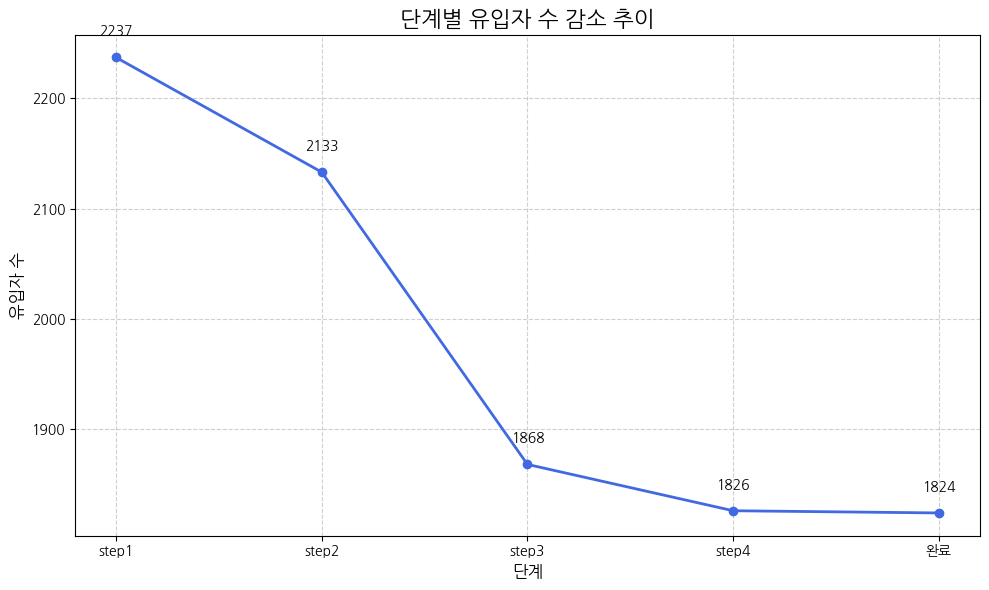

In [214]:
# 단계 이름과 유입자 수 (너의 실제 값으로 바꿔줘)
stage_names = ["step1", "step2", "step3", "step4", "완료"]
counts = [apply_step_1_number, apply_step_2_number, apply_step_3_number, apply_step_4_number, apply_step_4_api_number]

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(stage_names, counts, marker='o', linestyle='-', color='royalblue', linewidth=2)
plt.title("단계별 유입자 수 감소 추이", fontsize=16)
plt.xlabel("단계", fontsize=12)
plt.ylabel("유입자 수", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 각 점에 유입자 수 표시
for i, count in enumerate(counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 최종 합격한 사람 (@user_id/applications?status=passed)

In [221]:
log_passed_members = log_2022_df[log_2022_df['URL'] == "@user_id/applications?status=passed"]["user_uuid"].unique()

In [222]:
finally_passed_df = apply_step_4_api_df[apply_step_4_api_df['user_uuid'].isin(log_passed_members)]
finally_passed_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
2436490,2436490,c003e946-1735-45fd-8705-7c01cca13654,api/jobs/id/apply/step4,2022-01-11 15:59:55.871142,2022-01-12,200,POST,api/jobs/id/apply/step4
2437561,2437561,c003e946-1735-45fd-8705-7c01cca13654,api/jobs/id/apply/step4,2022-01-11 16:01:04.856163,2022-01-12,200,POST,api/jobs/id/apply/step4
2437586,2437586,c003e946-1735-45fd-8705-7c01cca13654,api/jobs/id/apply/step4,2022-01-11 16:10:11.409391,2022-01-12,200,POST,api/jobs/id/apply/step4
2437801,2437801,c003e946-1735-45fd-8705-7c01cca13654,api/jobs/id/apply/step4,2022-01-11 16:12:50.983437,2022-01-12,200,POST,api/jobs/id/apply/step4
2438051,2438051,c003e946-1735-45fd-8705-7c01cca13654,api/jobs/id/apply/step4,2022-01-11 16:21:40.009640,2022-01-12,200,POST,api/jobs/id/apply/step4
...,...,...,...,...,...,...,...,...
8319746,8319746,c912c8ac-86fa-4940-a66c-33a8b580c143,api/jobs/id/apply/step4,2022-12-28 08:48:14.991997,2022-12-28,200,POST,api/jobs/id/apply/step4
8275719,8275719,967b481a-19fc-4904-b480-28a251f1e019,api/jobs/id/apply/step4,2022-12-29 05:26:32.070208,2022-12-29,200,POST,api/jobs/id/apply/step4
3090181,3090181,12a72de4-d4ff-49e2-abc2-2c4279eeffa9,api/jobs/id/apply/step4,2022-12-29 08:44:38.008301,2022-12-29,200,POST,api/jobs/id/apply/step4
3089986,3089986,12a72de4-d4ff-49e2-abc2-2c4279eeffa9,api/jobs/id/apply/step4,2022-12-29 14:52:32.056421,2022-12-29,200,POST,api/jobs/id/apply/step4


In [223]:
apply_step_4_api_df["user_uuid"].nunique()

1824

In [224]:
finally_passed_df["user_uuid"].nunique()

135

In [225]:
finally_passed_members = finally_passed_df["user_uuid"].unique()

## 최종 합격자 제외 인터뷰 합격자

In [226]:
not_finally_passed_df = apply_step_4_api_df[~apply_step_4_api_df["user_uuid"].isin(finally_passed_members)]

In [227]:
not_finally_passed_members = not_finally_passed_df["user_uuid"].unique()

In [228]:
log_interview_passed_members = log_2022_df[log_2022_df['URL'] == "@user_id/applications?status=interview-passed"]["user_uuid"].unique()

In [229]:
interview_passed_df = not_finally_passed_df[not_finally_passed_df['user_uuid'].isin(log_interview_passed_members)]
interview_passed_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
5754368,5754368,327e09c2-ecd7-4dd4-b554-128eb6e48f56,api/jobs/id/apply/step4,2022-01-10 01:33:41.223030,2022-01-10,200,POST,api/jobs/id/apply/step4
5754680,5754680,327e09c2-ecd7-4dd4-b554-128eb6e48f56,api/jobs/id/apply/step4,2022-01-10 01:56:01.375900,2022-01-10,200,POST,api/jobs/id/apply/step4
5753761,5753761,327e09c2-ecd7-4dd4-b554-128eb6e48f56,api/jobs/id/apply/step4,2022-01-12 02:43:43.805372,2022-01-12,200,POST,api/jobs/id/apply/step4
5754130,5754130,327e09c2-ecd7-4dd4-b554-128eb6e48f56,api/jobs/id/apply/step4,2022-01-13 14:04:56.492851,2022-01-13,200,POST,api/jobs/id/apply/step4
2069762,2069762,520a2b7f-34c8-4323-8f8d-41269a65ab19,api/jobs/id/apply/step4,2022-01-15 15:04:10.046428,2022-01-16,200,POST,api/jobs/id/apply/step4
...,...,...,...,...,...,...,...,...
4893693,4893693,735b3857-387b-4642-8e6e-ce539e9e5724,api/jobs/id/apply/step4,2022-12-21 07:54:40.272389,2022-12-21,200,POST,api/jobs/id/apply/step4
4893211,4893211,735b3857-387b-4642-8e6e-ce539e9e5724,api/jobs/id/apply/step4,2022-12-21 11:07:58.041100,2022-12-21,200,POST,api/jobs/id/apply/step4
7682556,7682556,c34cb276-0032-4daf-a9f5-e4095501afce,api/jobs/id/apply/step4,2022-12-22 05:03:47.926526,2022-12-22,200,POST,api/jobs/id/apply/step4
5326585,5326585,a8e08d67-6866-41d7-8d3d-9c6cb750837c,api/jobs/id/apply/step4,2022-12-26 11:01:56.121935,2022-12-26,200,POST,api/jobs/id/apply/step4


In [230]:
len(not_finally_passed_members)

1689

In [231]:
interview_passed_df["user_uuid"].nunique()

66

In [232]:
interview_passed_members = interview_passed_df["user_uuid"].unique()

## 인터뷰 합격자 제외 서류 합격자

In [233]:
not_interview_passed_df = not_finally_passed_df[~not_finally_passed_df["user_uuid"].isin(interview_passed_members)]

In [234]:
not_interview_passed_members = not_interview_passed_df["user_uuid"].unique()

In [235]:
log_application_passed_members = log_2022_df[log_2022_df['URL'] == "@user_id/applications?status=application-passed"]["user_uuid"].unique()

In [236]:
application_passed_df = not_interview_passed_df[not_interview_passed_df['user_uuid'].isin(log_application_passed_members)]
application_passed_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
6274826,6274826,41df8ee1-14cb-4766-b266-ee5c0e9f175b,api/jobs/id/apply/step4,2022-01-03 14:57:43.497563,2022-01-03,200,POST,api/jobs/id/apply/step4
6275129,6275129,41df8ee1-14cb-4766-b266-ee5c0e9f175b,api/jobs/id/apply/step4,2022-01-03 15:33:44.033871,2022-01-04,200,POST,api/jobs/id/apply/step4
6275683,6275683,41df8ee1-14cb-4766-b266-ee5c0e9f175b,api/jobs/id/apply/step4,2022-01-04 10:01:12.458811,2022-01-04,200,POST,api/jobs/id/apply/step4
9451750,9451750,d3791607-33fd-463f-8935-c9904a501b13,api/jobs/id/apply/step4,2022-01-07 04:45:19.279263,2022-01-07,200,POST,api/jobs/id/apply/step4
9451794,9451794,d3791607-33fd-463f-8935-c9904a501b13,api/jobs/id/apply/step4,2022-01-07 04:47:44.749007,2022-01-07,200,POST,api/jobs/id/apply/step4
...,...,...,...,...,...,...,...,...
9719705,9719705,325c27ba-36c5-4ddc-9725-52c15d89b8b0,api/jobs/id/apply/step4,2022-12-31 11:18:33.258163,2022-12-31,200,POST,api/jobs/id/apply/step4
9719701,9719701,325c27ba-36c5-4ddc-9725-52c15d89b8b0,api/jobs/id/apply/step4,2022-12-31 11:19:28.679943,2022-12-31,200,POST,api/jobs/id/apply/step4
9719111,9719111,325c27ba-36c5-4ddc-9725-52c15d89b8b0,api/jobs/id/apply/step4,2022-12-31 11:26:55.936841,2022-12-31,200,POST,api/jobs/id/apply/step4
9719086,9719086,325c27ba-36c5-4ddc-9725-52c15d89b8b0,api/jobs/id/apply/step4,2022-12-31 11:27:12.497992,2022-12-31,200,POST,api/jobs/id/apply/step4


In [237]:
not_interview_passed_df["user_uuid"].nunique()

1623

In [238]:
application_passed_df["user_uuid"].nunique()

204

In [239]:
application_passed_members = application_passed_df["user_uuid"].unique()

## 서류 합격까지 모두 제외

In [240]:
# numpy의 set 차집합 기능 사용
losers = np.setdiff1d(
    not_interview_passed_df["user_uuid"].unique(),
    application_passed_df["user_uuid"].unique()
)

In [241]:
len(losers)

1419

## 서류 합격 (total_application_passed_df) vs 불합격 (total_losers_df)

In [242]:
total_application_passed_members = apply_step_4_api_df[~apply_step_4_api_df["user_uuid"].isin(losers)]["user_uuid"].unique()
total_application_passed_df = log_2022_df[log_2022_df["user_uuid"].isin(total_application_passed_members)]
total_losers_df = log_2022_df[log_2022_df["user_uuid"].isin(losers)]

In [243]:
apply_step_4_api_df["user_uuid"].nunique()

1824

In [244]:
total_application_passed_df["user_uuid"].nunique()

405

In [245]:
total_losers_df["user_uuid"].nunique()

1419

## 페이지별 체류시간

### 2023년 해보기

In [248]:
log_2023_path = "/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/데이터 분석 중급 프로젝트_1/원본 데이터/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/이전/log_2023.csv"
log_2023_df = pd.read_csv(log_2023_path)

In [249]:
# 1. UTC 제거
log_2023_df["timestamp_clean"] = log_2023_df["timestamp"].str.replace(" UTC", "", regex=False)

# 2. datetime으로 변환
log_2023_df["timestamp_clean"] = pd.to_datetime(
    log_2023_df["timestamp_clean"],
    format="%Y-%m-%d %H:%M:%S.%f",
    errors="coerce"
)

# 3. NaT가 생긴 경우, 포맷이 다른 문자열을 다시 처리 (마이크로초 없는 경우 등)
mask_failed = log_2023_df["timestamp_clean"].isna()
log_2023_df.loc[mask_failed, "timestamp_clean"] = pd.to_datetime(
    log_2023_df.loc[mask_failed, "timestamp"].str.replace(" UTC", "", regex=False),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

# 4. 정리
log_2023_df["timestamp"] = log_2023_df["timestamp_clean"]
log_2023_df.drop(columns="timestamp_clean", inplace=True)

In [250]:
# 쿼리 파라미터 제거
log_2023_df["cleaned_url"] = log_2023_df["URL"].str.split("?").str[0]

In [251]:
step_keywords = ['step1', 'step2', 'step3', 'step4']

step_mask = log_2023_df["cleaned_url"].apply(
    lambda url: isinstance(url, str) and any(kw in url for kw in step_keywords)
)
step_logs = log_2023_df[step_mask].copy()

# 2. user + timestamp 기준 정렬 후 체류 시간 계산
step_logs = step_logs.sort_values(by=["user_uuid", "timestamp"])
step_logs["next_timestamp"] = step_logs.groupby("user_uuid")["timestamp"].shift(-1)
step_logs["stay_duration"] = (step_logs["next_timestamp"] - step_logs["timestamp"]).dt.total_seconds()

# 3. step 추출: numpy array + vectorized 방식
step_map = {kw: kw for kw in step_keywords}
step_logs["step"] = np.select(
    [step_logs["cleaned_url"].str.contains(kw, na=False) for kw in step_keywords],
    step_keywords,
    default="기타"
)

# 4. 상태 분류: set을 활용한 빠른 조회
passed_users = set(total_application_passed_df["user_uuid"])
failed_users = set(total_losers_df["user_uuid"])

def classify_status(user_uuid):
    if user_uuid in passed_users:
        return "합격자"
    elif user_uuid in failed_users:
        return "불합격자"
    else:
        return "기타"

step_logs["status"] = step_logs["user_uuid"].map(classify_status)

# 5. 체류시간 2초 이하 제거
step_logs = step_logs[step_logs["stay_duration"] > 2]

# 6. 최종 평균 체류시간 계산
step_time_stats = step_logs[step_logs["status"].isin(["합격자", "불합격자"])] \
    .groupby(["status", "step"])["stay_duration"].mean().reset_index()

# 초 → 분 변환
step_time_stats["stay_duration_minutes"] = (step_time_stats["stay_duration"] / 60).round(2)

# 결과 보기 좋게 정리
step_time_stats = step_time_stats[["status", "step", "stay_duration_minutes"]]

### 수정본

In [253]:
step_mask = log_2022_df["cleaned_url"].apply(
    lambda url: isinstance(url, str) and any(kw in url for kw in step_keywords)
)
step_logs = log_2022_df[step_mask].copy()

# 2. user + timestamp 기준 정렬 후 체류 시간 계산
step_logs = step_logs.sort_values(by=["user_uuid", "timestamp"])
step_logs["next_timestamp"] = step_logs.groupby("user_uuid")["timestamp"].shift(-1)
step_logs["stay_duration"] = (step_logs["next_timestamp"] - step_logs["timestamp"]).dt.total_seconds()

# 3. step 추출: numpy array + vectorized 방식
step_map = {kw: kw for kw in step_keywords}
step_logs["step"] = np.select(
    [step_logs["cleaned_url"].str.contains(kw, na=False) for kw in step_keywords],
    step_keywords,
    default="기타"
)

# 4. 상태 분류: set을 활용한 빠른 조회
passed_users = set(total_application_passed_df["user_uuid"])
failed_users = set(total_losers_df["user_uuid"])

def classify_status(user_uuid):
    if user_uuid in passed_users:
        return "합격자"
    elif user_uuid in failed_users:
        return "불합격자"
    else:
        return "기타"

step_logs["status"] = step_logs["user_uuid"].map(classify_status)

# 5. 체류시간 2초 이하 제거
step_logs = step_logs[step_logs["stay_duration"] > 2]

# 6. 최종 평균 체류시간 계산
step_time_stats = step_logs[step_logs["status"].isin(["합격자", "불합격자"])] \
    .groupby(["status", "step"])["stay_duration"].mean().reset_index()

# 초 → 분 변환
step_time_stats["stay_duration_minutes"] = (step_time_stats["stay_duration"] / 60).round(2)

# 결과 보기 좋게 정리
step_time_stats = step_time_stats[["status", "step", "stay_duration_minutes"]]

In [254]:
step_time_stats

,status,step,stay_duration_minutes
0,불합격자,step1,1282.32
1,불합격자,step2,823.04
2,불합격자,step3,2663.53
3,불합격자,step4,2370.78
4,합격자,step1,976.95
5,합격자,step2,473.47
6,합격자,step3,1807.89
7,합격자,step4,1419.21


<ipython-input-255-c6c7092daad8>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



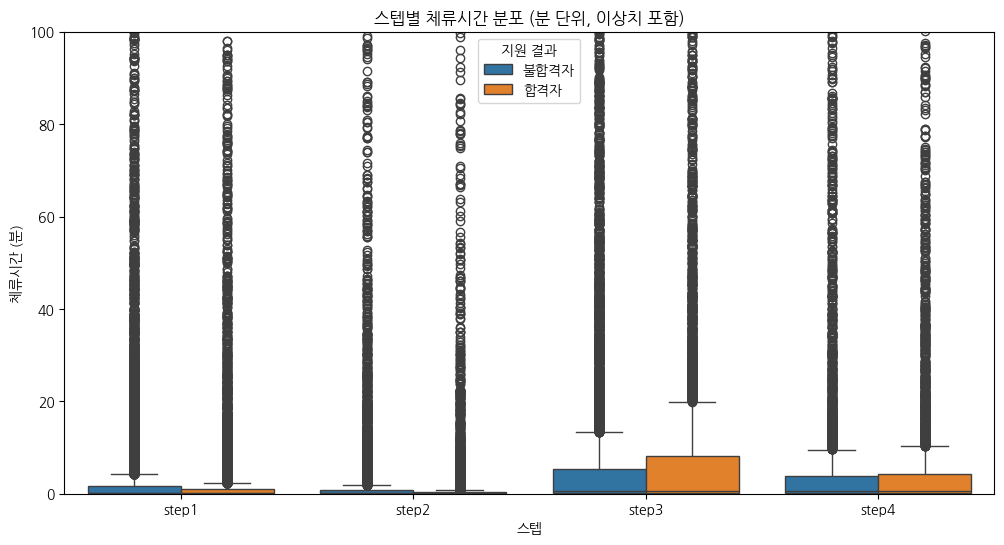

In [255]:
# 체류시간을 분 단위로 변환
step_logs["stay_minutes"] = (step_logs["stay_duration"] / 60).round(2)

# 합격자/불합격자 중에서만 확인
filtered = step_logs[step_logs["status"].isin(["합격자", "불합격자"])]

# Boxplot으로 이상치 확인
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered, x="step", y="stay_minutes", hue="status")
plt.ylim(0, 100)  # 범위 제한해서 보기 좋게
plt.title("스텝별 체류시간 분포 (분 단위, 이상치 포함)")
plt.ylabel("체류시간 (분)")
plt.xlabel("스텝")
plt.legend(title="지원 결과")
plt.show()

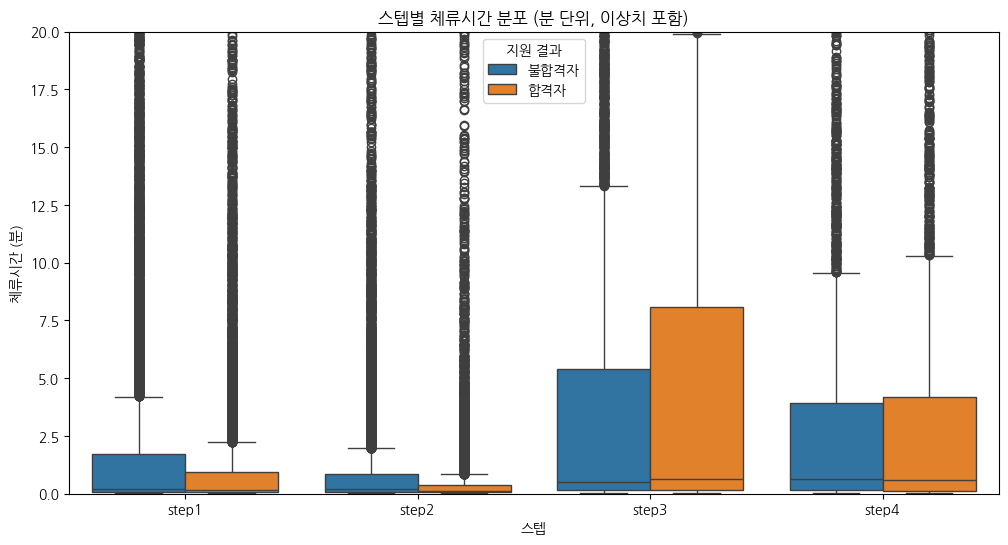

In [256]:
# 체류시간을 분 단위로 변환
step_logs["stay_minutes"] = (step_logs["stay_duration"] / 60).round(2)

# 합격자/불합격자 중에서만 확인
filtered = step_logs[step_logs["status"].isin(["합격자", "불합격자"])]

# Boxplot으로 이상치 확인
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered, x="step", y="stay_minutes", hue="status")
plt.ylim(0, 20)
plt.title("스텝별 체류시간 분포 (분 단위, 이상치 포함)")
plt.ylabel("체류시간 (분)")
plt.xlabel("스텝")
plt.legend(title="지원 결과")
plt.show()

만능 대답: 주어진 데이터 내에서는 더 확인할 수 없었다

In [257]:
# 체류시간을 분 단위로 변환
step_logs["stay_minutes"] = (step_logs["stay_duration"] / 60).round(2)

# 합격자/불합격자만 대상으로
filtered = step_logs[step_logs["status"].isin(["합격자", "불합격자"])]

# 스텝별 + 상태별 중앙값 계산
median_stats = filtered.groupby(["status", "step"])["stay_minutes"].median().reset_index()

# 보기 좋게 정렬
median_stats = median_stats.sort_values(by=["status", "step"]).reset_index(drop=True)

# 결과 출력
median_stats

,status,step,stay_minutes
0,불합격자,step1,0.22
1,불합격자,step2,0.20
2,불합격자,step3,0.50
3,불합격자,step4,0.63
4,합격자,step1,0.15
5,합격자,step2,0.12
6,합격자,step3,0.65
7,합격자,step4,0.61


In [258]:
# 체류시간 분 단위로 변환
step_logs["stay_minutes"] = step_logs["stay_duration"] / 60
filtered = step_logs[step_logs["status"].isin(["합격자", "불합격자"])]

# 이상치 제거 함수 정의
def remove_iqr_outliers(df):
    result = []

    for (status, step), group in df.groupby(["status", "step"]):
        q1 = group["stay_minutes"].quantile(0.25)
        q3 = group["stay_minutes"].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr

        cleaned_group = group[(group["stay_minutes"] <= upper_bound) & (group["stay_minutes"] >= lower_bound)].copy()
        result.append(cleaned_group)

    return pd.concat(result)

# IQR 기반 이상치 제거
filtered_clean = remove_iqr_outliers(filtered)

# 이상치 제거 후 평균 체류시간 재계산
mean_stats_iqr = filtered_clean.groupby(["status", "step"])["stay_minutes"].mean().reset_index()
mean_stats_iqr["stay_minutes"] = mean_stats_iqr["stay_minutes"].round(2)

mean_stats_iqr

,status,step,stay_minutes
0,불합격자,step1,0.48
1,불합격자,step2,0.33
2,불합격자,step3,1.26
3,불합격자,step4,1.09
4,합격자,step1,0.27
5,합격자,step2,0.16
6,합격자,step3,1.82
7,합격자,step4,1.12


- 지금까지 본거는 근거 AARRR 이랑 상관 없음

- 예시)이 근거를 바탕으로 step3에서 작성 가이드라인을 세분화
    - 기대효과: 지원을 할 때 가이드라인이 세분화된 지원서에서 작성을 해요 -> 기존 대비 합격률이 올라요

- 기존 프레임워크에 적용
    - 획득해서 활성화하는 사람들의 리텐션을 올리기 위해
        - 사용자가 좋은 경험을 했다고 느끼면(원티드랑 로켓펀치에서 똑같은데에 지원했는데 로켓펀치에서 지원한 서류는 합격했더라)
            - 이 플랫폼을 지속적으로 이용할 동기가 된다

- 여기서 의문
    - 그러면 첫 지원에서 합격하지 못해서 이 플랫폼을 더이상 사용하지 않았을거다 라는 근거가 있나?
    - 첫 지원에서의 합격과 리텐션이 연관이 있나?
        - 그 근거를 찾아야 위 내용을 적용할 수 있나?

- step3 필수 아닌데도 작성한 사람들 중 더 자세하게 작성한 사람이 더 합격률이 높았다

- 최종 주제
    - 1. 합격이 리텐션에 영향이 있다
        - step3 강화 -> 합격률 증가 -> 리텐션 개선
    - 2. 없다
        - 활성화 -> 합격률 증가 -> 기존 대비 긍정적 경험 재고

GOOD GOOD VERY GOOD

## 합격자 vs 불합격자 리텐션 분석

### 불합격자 월별 코호트 리텐션 차트 그리기

In [259]:
# 불합격자
total_losers_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
0,0,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/search/language?name=한국어&_=1655915651225,2022-06-22 16:42:48.247454,2022-06-23,200,GET,api/search/language
1,1,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/signup/form,2022-06-22 16:19:07.770741,2022-06-23,200,POST,api/signup/form
2,2,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/users/id/template,2022-06-22 16:41:54.449837,2022-06-23,200,POST,api/users/id/template
3,3,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/users/id/template,2022-06-23 02:53:47.040932,2022-06-23,200,POST,api/users/id/template
4,4,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/users/id/phone/verify/template?_=165591488...,2022-06-22 16:21:58.154299,2022-06-23,200,GET,api/users/id/phone/verify/template
...,...,...,...,...,...,...,...,...
10051170,10051170,cec231eb-8a0a-4370-a88c-451cac3b5348,api/search/people/job_title?name=SW &_=1669783...,2022-11-30 04:43:56.782707,2022-11-30,200,GET,api/search/people/job_title
10051171,10051171,cec231eb-8a0a-4370-a88c-451cac3b5348,signup/step3/discover,2022-11-30 04:44:14.474273,2022-11-30,200,GET,signup/step3/discover
10051172,10051172,cec231eb-8a0a-4370-a88c-451cac3b5348,api/search/people/job_title?name=iOS A&_=16697...,2022-11-30 04:43:48.395248,2022-11-30,200,GET,api/search/people/job_title
10051173,10051173,cec231eb-8a0a-4370-a88c-451cac3b5348,api/recommend_specialty,2022-11-30 04:45:18.906359,2022-11-30,200,POST,api/recommend_specialty


In [260]:
loser_logs = log_2022_df[log_2022_df["user_uuid"].isin(total_losers_df["user_uuid"])].copy()

loser_logs["timestamp"] = pd.to_datetime(loser_logs["timestamp"])
loser_logs["activity_month"] = loser_logs["timestamp"].dt.to_period("M").dt.to_timestamp()


loser_logs["cohort_month"] = loser_logs.groupby("user_uuid")["timestamp"].transform("min").dt.to_period("M").dt.to_timestamp()


loser_logs["month_index"] = (
    (loser_logs["activity_month"].dt.to_period("M") - loser_logs["cohort_month"].dt.to_period("M"))
).apply(lambda x: x.n)

#  코호트별 월간 활동 유저 수 계산
cohort_counts = loser_logs.groupby(["cohort_month", "month_index"])["user_uuid"].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index="cohort_month", columns="month_index", values="user_uuid")

# 리텐션율 계산
cohort_sizes = cohort_pivot[0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

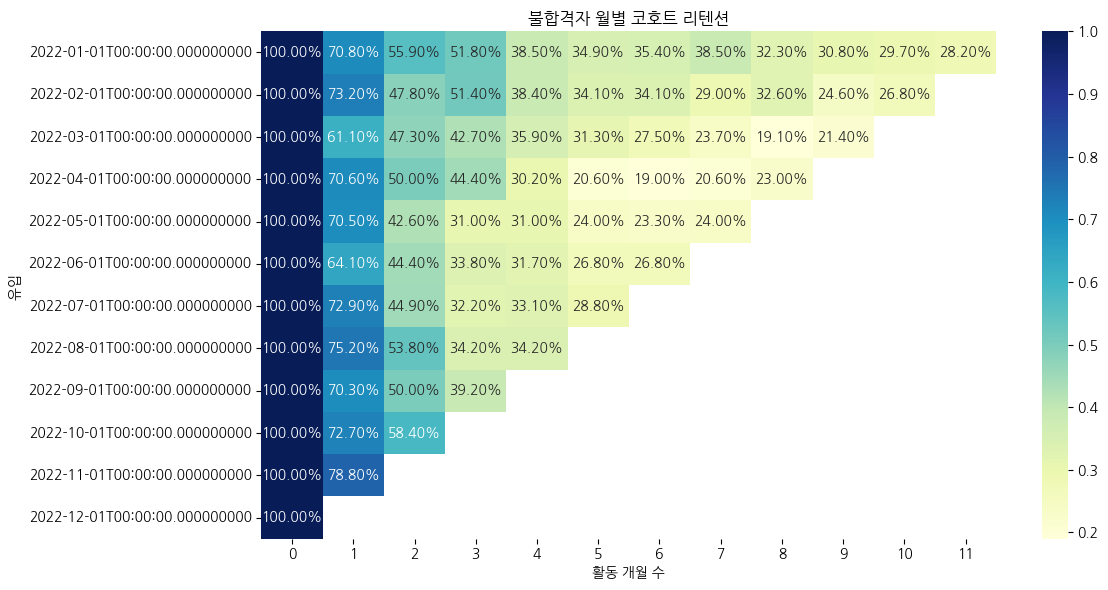

In [261]:
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("불합격자 월별 코호트 리텐션")
plt.xlabel("활동 개월 수")
plt.ylabel("유입 ")
plt.tight_layout()
plt.show()

### 합격자 월별 코호트 리텐션 차트 그리기

In [262]:
# 합격자
total_application_passed_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
101395,101395,85012ac6-240f-4ccd-bdc0-1ef32de35663,@user_id,2022-06-23 11:36:02.379104,2022-06-23,200,GET,@user_id
101396,101396,85012ac6-240f-4ccd-bdc0-1ef32de35663,@user_id/resume,2022-06-23 03:52:11.155042,2022-06-23,200,GET,@user_id/resume
101397,101397,85012ac6-240f-4ccd-bdc0-1ef32de35663,@user_id/job_offer/received?type=accepted,2022-06-23 03:50:42.901675,2022-06-23,200,GET,@user_id/job_offer/received
101398,101398,85012ac6-240f-4ccd-bdc0-1ef32de35663,api/users/id/template,2022-06-23 03:59:45.945173,2022-06-23,200,POST,api/users/id/template
101399,101399,85012ac6-240f-4ccd-bdc0-1ef32de35663,api/people/template?page=&q=&rel=1,2022-06-23 08:45:19.199971,2022-06-23,200,GET,api/people/template
...,...,...,...,...,...,...,...,...
9956165,9956165,2c75b724-0ce4-437f-b199-8dc424d94eea,api/recommend_specialty,2022-05-03 14:04:41.804259,2022-05-03,200,POST,api/recommend_specialty
9956166,9956166,2c75b724-0ce4-437f-b199-8dc424d94eea,api/jobs/id/other_jobs?offset=0&limit=5,2022-06-27 14:02:08.589277,2022-06-27,200,GET,api/jobs/id/other_jobs
9956167,9956167,2c75b724-0ce4-437f-b199-8dc424d94eea,api/jobs/id/other_jobs?offset=0&limit=5,2022-06-27 13:57:27.056983,2022-06-27,200,GET,api/jobs/id/other_jobs
9956168,9956168,2c75b724-0ce4-437f-b199-8dc424d94eea,companies/company_id/jobs,2022-06-27 13:57:03.141219,2022-06-27,200,GET,companies/company_id/jobs


In [263]:
total_application_passed_df["timestamp"] = pd.to_datetime(total_application_passed_df["timestamp"])
total_application_passed_df["activity_month"] = total_application_passed_df["timestamp"].dt.to_period("M").dt.to_timestamp()


total_application_passed_df["cohort_month"] = total_application_passed_df.groupby("user_uuid")["timestamp"].transform("min").dt.to_period("M").dt.to_timestamp()


total_application_passed_df["month_index"] = (
    (total_application_passed_df["activity_month"].dt.to_period("M") - total_application_passed_df["cohort_month"].dt.to_period("M"))
).apply(lambda x: x.n)

#  코호트별 월간 활동 유저 수 계산
cohort_counts = total_application_passed_df.groupby(["cohort_month", "month_index"])["user_uuid"].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index="cohort_month", columns="month_index", values="user_uuid")

# 리텐션율 계산
cohort_sizes = cohort_pivot[0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

<ipython-input-263-ed5daa572d14>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-263-ed5daa572d14>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-263-ed5daa572d14>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-263-ed5

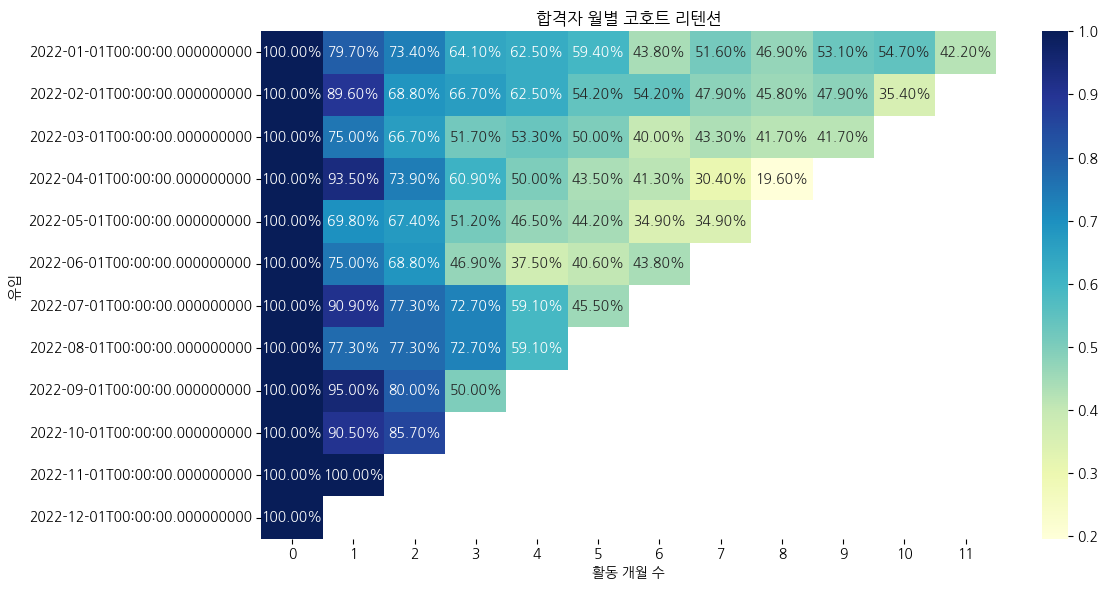

In [264]:
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("합격자 월별 코호트 리텐션")
plt.xlabel("활동 개월 수")
plt.ylabel("유입 ")
plt.tight_layout()
plt.show()

In [265]:
total_losers_df["user_uuid"].nunique()

1419

???: 400명으로 맞추면?

In [266]:
total_application_passed_df["user_uuid"].nunique()

405

### 불합격자 수 405명(random_losers_df)으로 다시 해보기

In [267]:
loser_members = total_losers_df["user_uuid"].unique()

In [268]:
random_loser_members = np.random.choice(loser_members, size=405, replace=False)

In [269]:
random_losers_df = total_losers_df[total_losers_df["user_uuid"].isin(random_loser_members)]

In [270]:
loser_logs = log_2022_df[log_2022_df["user_uuid"].isin(random_losers_df["user_uuid"])].copy()

loser_logs["timestamp"] = pd.to_datetime(loser_logs["timestamp"])
loser_logs["activity_month"] = loser_logs["timestamp"].dt.to_period("M").dt.to_timestamp()


loser_logs["cohort_month"] = loser_logs.groupby("user_uuid")["timestamp"].transform("min").dt.to_period("M").dt.to_timestamp()


loser_logs["month_index"] = (
    (loser_logs["activity_month"].dt.to_period("M") - loser_logs["cohort_month"].dt.to_period("M"))
).apply(lambda x: x.n)

#  코호트별 월간 활동 유저 수 계산
cohort_counts = loser_logs.groupby(["cohort_month", "month_index"])["user_uuid"].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index="cohort_month", columns="month_index", values="user_uuid")

# 리텐션율 계산
cohort_sizes = cohort_pivot[0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

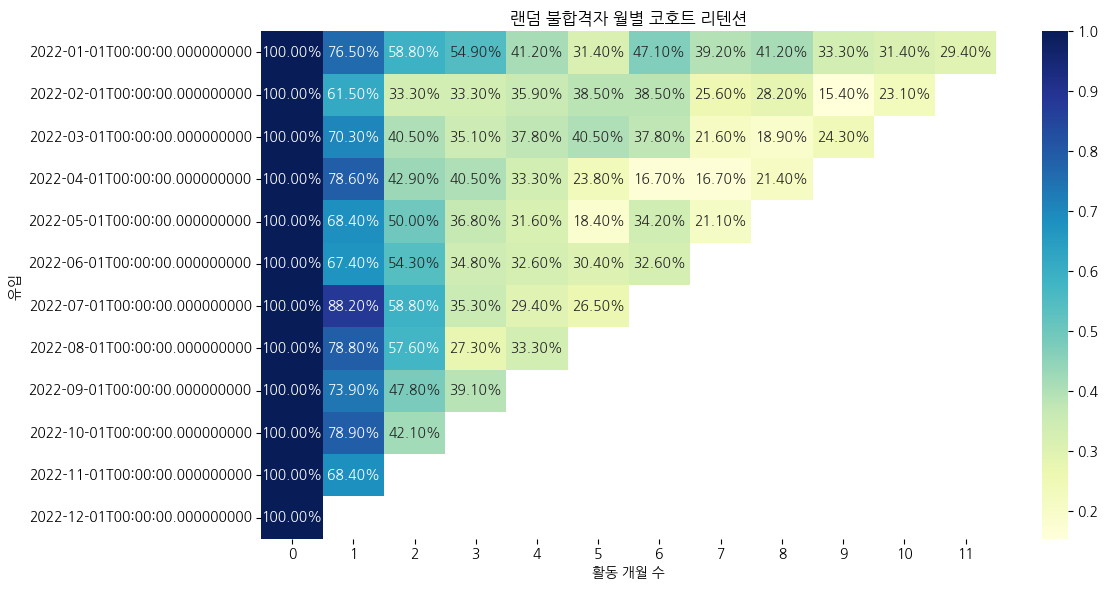

In [271]:
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("랜덤 불합격자 월별 코호트 리텐션")
plt.xlabel("활동 개월 수")
plt.ylabel("유입 ")
plt.tight_layout()
plt.show()

### 결론

- 월별 코호트 리텐션 차트를 확인하였을 때, 합격자들이 불합격자들보다 유지율이 높은 경향을 나타내는 것을 확인했다.
    - 최종 주제
        - 합격 여부가 리텐션에 영향이 있다
            - step3 강화 -> 합격률 증가 -> 리텐션 개선

- 합격자가 불합격자보다 리텐션이 높다
    - 합격할 확률을 높이면 리텐션이 개선될거다

- 질문 사항
    - 경향은 확인했지만 집단 별 유저의 수 차이가 있어서
    - 추가적으로 확인해야할 부분이 있을지?

- 행동패턴 확인
    - 합격자와 불합격자가 어떤 행동을 하는지?
    - 지원 관련 행동을 누가 더 많이 하는지?
    - step1, 2 에 대한 해석 -> 불합격자가 step1, 2에서 더 오래 있었는데 이게 어떤걸 의미하는지?

- step3 전후로 있는 로그 확인 (step3가 어떤 과정인지)
    - 그 로그 별로 체류시간 확인
    - 그룹간의 차이 비교하기
        - 추후 step3 한사람 안한사람 비교해서 합불 비율 확인

## 합격자와 불합격자 중 누가 더 지원을 많이 했는가?

In [272]:
# Step 1: 특정 cleaned_url 값 필터링
losers_apply_complete_df = total_losers_df[total_losers_df['cleaned_url'] == 'api/jobs/id/apply/step4']

# Step 2: user_uuid별로 groupby 후 count
losers_apply_complete_counts = losers_apply_complete_df.groupby('user_uuid').size()

# Step 3: 평균 계산
losers_apply_complete_average_count = losers_apply_complete_counts.mean()

print(f"불합격자의 평균 지원 완료 횟수: {losers_apply_complete_average_count}")

불합격자의 평균 지원 완료 횟수: 4.246652572233968


In [273]:
# Step 1: 특정 cleaned_url 값 필터링
passed_apply_complete_df = total_application_passed_df[total_application_passed_df['cleaned_url'] == 'api/jobs/id/apply/step4']

# Step 2: user_uuid별로 groupby 후 count
passed_apply_complete_counts = passed_apply_complete_df.groupby('user_uuid').size()

# Step 3: 평균 계산
passed_apply_complete_average_count = passed_apply_complete_counts.mean()

print(f"합격자의 평균 지원 완료 횟수: {passed_apply_complete_average_count}")

합격자의 평균 지원 완료 횟수: 12.481481481481481


- 지원을 더 많이 할 수록 합격할 확률이 높다
    - 더 많은 지원을 유도해서 합격률을 올린다
    - 행동 패턴 분석과 연계해서 탐색만 하지 말고 실제 지원 해봐~ 권장
    - ex) 비슷한 공고 여러번 방문한 유저에게 "구경만 하지 말고 지원 해봐" 라고 팝업 띄우기
    - ex) "이 공고의 마감이 얼마 남지 않았어요!!" 라는 팝업 띄우기
        - 리텐션 개선에 도움

## 합격 여부에 따른 행동 패턴 분석

In [274]:
passed_users = set(total_application_passed_df['user_uuid'])
failed_users = set(total_losers_df['user_uuid'])


log_2022_df['status'] = log_2022_df['user_uuid'].apply(
    lambda x: '합격자' if x in passed_users else ('불합격자' if x in failed_users else '기타')
)

# 합격자와 불합격자의 행동 패턴 비교, URL 기준 상위 20개 행동 비교
log_counts = log_2022_df[log_2022_df['status'].isin(['합격자', '불합격자'])] \
    .groupby(['status', 'cleaned_url'])['user_uuid'].count().reset_index()
log_counts.columns = ['status', 'cleaned_url', 'count']

# 상위 20개 행동
top_passed = log_counts[log_counts['status'] == '합격자'].sort_values(by='count', ascending=False).head(20)
top_failed = log_counts[log_counts['status'] == '불합격자'].sort_values(by='count', ascending=False).head(20)

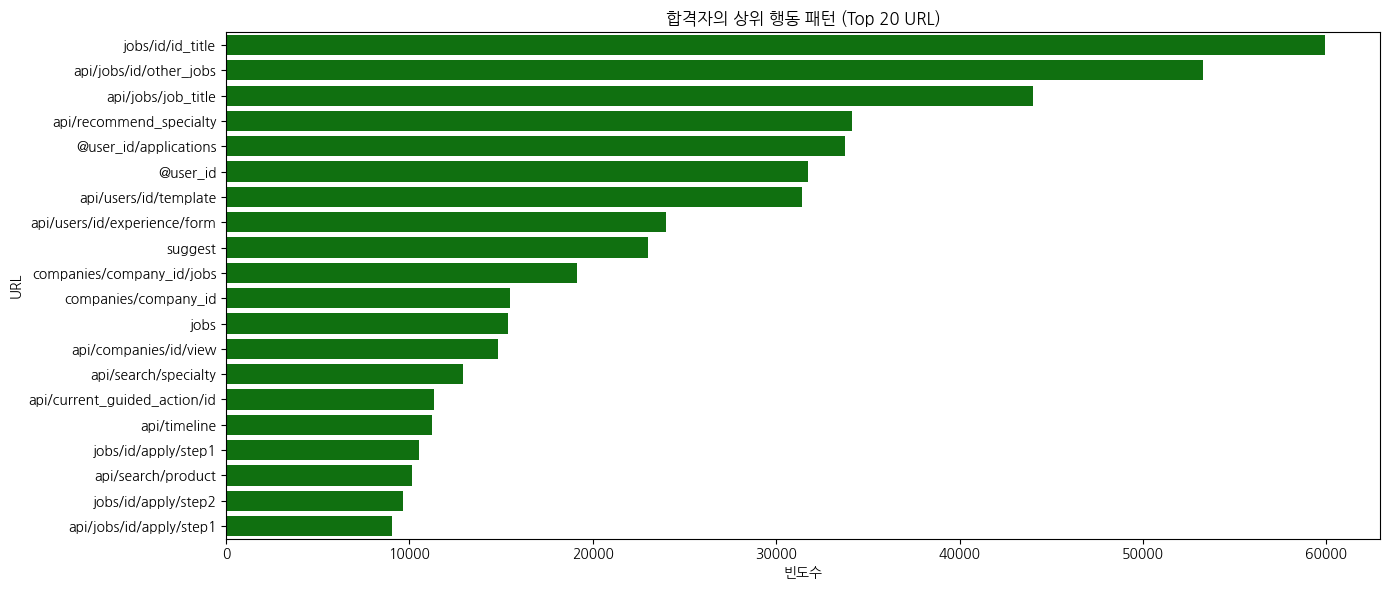

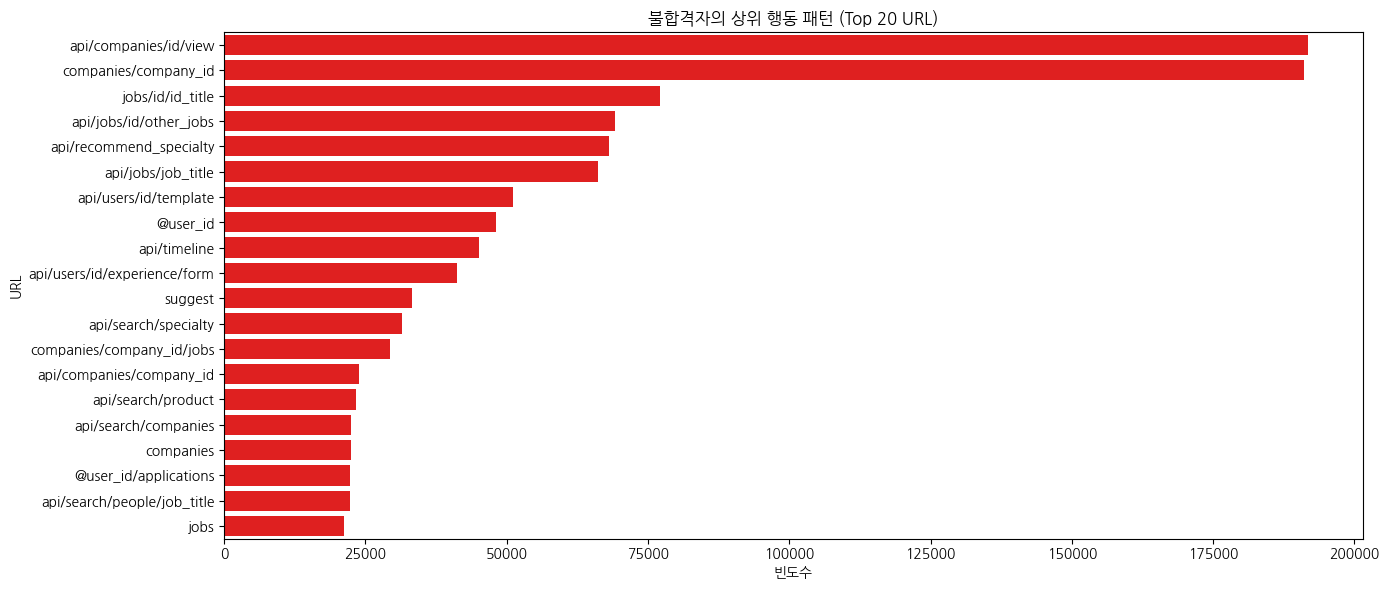

In [275]:
plt.figure(figsize=(14, 6))
sns.barplot(data=top_passed, x='count', y='cleaned_url', color='green')
plt.title("합격자의 상위 행동 패턴 (Top 20 URL)")
plt.xlabel("빈도수")
plt.ylabel("URL")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(data=top_failed, x='count', y='cleaned_url', color='red')
plt.title("불합격자의 상위 행동 패턴 (Top 20 URL)")
plt.xlabel("빈도수")
plt.ylabel("URL")
plt.tight_layout()
plt.show()

## step3 후 로그 확인 (step3 경로에 도달한 후 어떤 행동을 하는가)

In [276]:
# 유저별로 timestamp 순 정렬
log_2022_df = log_2022_df.sort_values(by=['user_uuid', 'timestamp'])

### step3 이후 5개

In [277]:
# 결과 저장할 리스트
results = []

# 유저별로 그룹핑
for user, group in log_2022_df.groupby('user_uuid'):
    group = group.reset_index(drop=True)

    # 'jobs/id/apply/step3'이 처음 등장하는 인덱스 찾기
    match_indices = group.index[group['cleaned_url'] == 'jobs/id/apply/step3'].tolist()

    for idx in match_indices:
        # 이후 10개의 로그 추출 (idx 포함해서 총 10개)
        subset = group.iloc[idx:idx+5]
        results.append(subset)

# 결과 합치기
after_step3_df = pd.concat(results, ignore_index=True)

# 결과 출력 (또는 저장 등)
after_step3_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,status
0,449933,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step3,2022-06-11 23:06:11.008202,2022-06-12,200,GET,jobs/id/apply/step3,기타
1,449922,0002535c-eacb-456b-a620-92c917332ba3,api/jobs/id/apply/step3,2022-06-11 23:06:16.756018,2022-06-12,400,POST,api/jobs/id/apply/step3,기타
2,449997,0002535c-eacb-456b-a620-92c917332ba3,continue?next=/@kyungmeejung/job_offer/received,2022-06-21 02:20:46.512750,2022-06-21,302,GET,continue,기타
3,449859,0002535c-eacb-456b-a620-92c917332ba3,@user_id/job_offer/received?utm_source=notific...,2022-06-21 02:20:47.094849,2022-06-21,200,GET,@user_id/job_offer/received,기타
4,450014,0002535c-eacb-456b-a620-92c917332ba3,api/job_offer/id/modal?type=received&_=1655778...,2022-06-21 02:21:01.616304,2022-06-21,200,GET,api/job_offer/id/modal,기타
...,...,...,...,...,...,...,...,...,...
323998,9730845,fff8a5c0-c85b-4e30-a22d-ed61b4480615,jobs/id/apply/step3,2022-04-29 11:24:45.192987,2022-04-29,200,GET,jobs/id/apply/step3,기타
323999,9730993,fff8a5c0-c85b-4e30-a22d-ed61b4480615,api/jobs/id/apply/step3,2022-04-29 11:25:53.861747,2022-04-29,200,POST,api/jobs/id/apply/step3,기타
324000,9730854,fff8a5c0-c85b-4e30-a22d-ed61b4480615,jobs/id/apply/step4,2022-04-29 11:25:54.163180,2022-04-29,200,GET,jobs/id/apply/step4,기타
324001,9730994,fff8a5c0-c85b-4e30-a22d-ed61b4480615,companies/company_id,2022-05-02 03:19:01.622581,2022-05-02,200,GET,companies/company_id,기타


In [278]:
# step3 이후의 행동만 추출 (step3 자체는 제외)
after_only_df = after_step3_df[after_step3_df['cleaned_url'] != 'jobs/id/apply/step3']

# 행동별 전체 카운트 집계
after_step3_top10_actions = (
    after_only_df['cleaned_url']
    .value_counts()
    .reset_index()
)

# 컬럼 이름 정리
after_step3_top10_actions.columns = ['cleaned_url', 'count']

# 결과 출력
after_step3_top10_actions

,cleaned_url,count
0,api/jobs/id/apply/step3,43271
1,jobs/id/apply/step4,29883
2,jobs/id/id_title,22376
3,api/jobs/id/apply/step4,22216
4,api/jobs/id/other_jobs,12262
...,...,...
154,api/users/id/career,1
155,api/guided_action/add_news_card/id,1
156,api/guided_action/add_funding_card/id,1
157,api/users/id/project,1


### step3 바로 직후

In [279]:
# 결과 저장할 리스트
results = []

# 유저별로 그룹핑
for user, group in log_2022_df.groupby('user_uuid'):
    group = group.reset_index(drop=True)

    # 'jobs/id/apply/step3'이 처음 등장하는 인덱스 찾기
    match_indices = group.index[group['cleaned_url'] == 'jobs/id/apply/step3'].tolist()

    for idx in match_indices:
        # 이후 10개의 로그 추출 (idx 포함해서 총 10개)
        subset = group.iloc[idx:idx+2]
        results.append(subset)

# 결과 합치기
next_step3_df = pd.concat(results, ignore_index=True)

# 결과 출력 (또는 저장 등)
next_step3_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,status
0,449933,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step3,2022-06-11 23:06:11.008202,2022-06-12,200,GET,jobs/id/apply/step3,기타
1,449922,0002535c-eacb-456b-a620-92c917332ba3,api/jobs/id/apply/step3,2022-06-11 23:06:16.756018,2022-06-12,400,POST,api/jobs/id/apply/step3,기타
2,449877,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step3,2022-07-23 04:06:52.749883,2022-07-23,200,GET,jobs/id/apply/step3,기타
3,449937,0002535c-eacb-456b-a620-92c917332ba3,api/jobs/id/apply/step3,2022-07-23 04:07:41.363913,2022-07-23,200,POST,api/jobs/id/apply/step3,기타
4,449852,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step3,2022-07-23 04:08:24.788796,2022-07-23,200,GET,jobs/id/apply/step3,기타
...,...,...,...,...,...,...,...,...,...
129689,9730899,fff8a5c0-c85b-4e30-a22d-ed61b4480615,jobs/id/apply/step2,2022-04-29 11:22:54.966932,2022-04-29,200,GET,jobs/id/apply/step2,기타
129690,9730866,fff8a5c0-c85b-4e30-a22d-ed61b4480615,jobs/id/apply/step3,2022-04-29 11:23:07.581043,2022-04-29,200,GET,jobs/id/apply/step3,기타
129691,9730784,fff8a5c0-c85b-4e30-a22d-ed61b4480615,api/jobs/id/apply/step3,2022-04-29 11:23:09.033571,2022-04-29,200,POST,api/jobs/id/apply/step3,기타
129692,9730845,fff8a5c0-c85b-4e30-a22d-ed61b4480615,jobs/id/apply/step3,2022-04-29 11:24:45.192987,2022-04-29,200,GET,jobs/id/apply/step3,기타


In [281]:
# step3 이후의 행동만 분석 (step3 자체는 제외)
after_only_df = after_step3_df[after_step3_df['cleaned_url'] != 'jobs/id/apply/step3']

# 행동별 카운트 계산
action_counts = (
    after_only_df
    .groupby(['user_uuid', 'cleaned_url'])
    .size()
    .reset_index(name='count')
)

# 유저별 상위 5개 행동 추출
top5_per_user = (
    action_counts
    .sort_values(['user_uuid', 'count'], ascending=[True, False])
    .groupby('user_uuid')
    .head(5)
    .reset_index(drop=True)
)

# 보기 좋게 출력
top5_per_user

,user_uuid,cleaned_url,count
0,0002535c-eacb-456b-a620-92c917332ba3,api/jobs/id/apply/step3,7
1,0002535c-eacb-456b-a620-92c917332ba3,api/jobs/job_title,3
2,0002535c-eacb-456b-a620-92c917332ba3,continue,3
3,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step4,3
4,0002535c-eacb-456b-a620-92c917332ba3,@user_id/job_offer/received,2
...,...,...,...
26429,fff8a5c0-c85b-4e30-a22d-ed61b4480615,api/users/id/experience/form,7
26430,fff8a5c0-c85b-4e30-a22d-ed61b4480615,api/jobs/id/apply/step3,5
26431,fff8a5c0-c85b-4e30-a22d-ed61b4480615,jobs/id/apply/step2,5
26432,fff8a5c0-c85b-4e30-a22d-ed61b4480615,companies/company_id/jobs,3


In [282]:
# step3 이후의 행동만 추출 (step3 자체는 제외)
next_only_df = next_step3_df[next_step3_df['cleaned_url'] != 'jobs/id/apply/step3']

# 행동별 전체 카운트 집계
next_step3_top10_actions = (
    next_only_df['cleaned_url']
    .value_counts()
    .reset_index()
)

# 컬럼 이름 정리
next_step3_top10_actions.columns = ['cleaned_url', 'count']

# 결과 출력
next_step3_top10_actions

,cleaned_url,count
0,api/jobs/id/apply/step3,32394
1,jobs/id/apply/step2,6574
2,jobs/id/id_title,5347
3,companies/company_id/jobs,2218
4,jobs/id/apply/step1,2089
...,...,...
98,companies/company_id/jobs/job_title,1
99,api/users/id/specialty,1
100,api/references,1
101,api/users/id/media,1


### 결론

- 어쨋거나 로그데이터만으로 step3 내에서 어떤 내용을 작성하는지는 알 수 없다.

## step1, 2에 대한 해석

In [283]:
# 결과 저장할 리스트
results = []

# 유저별로 그룹핑
for user, group in log_2022_df.groupby('user_uuid'):
    group = group.reset_index(drop=True)

    # 'jobs/id/apply/step3'이 처음 등장하는 인덱스 찾기
    match_indices = group.index[group['cleaned_url'] == 'jobs/id/apply/step1'].tolist()

    for idx in match_indices:
        # 이후 10개의 로그 추출 (idx 포함해서 총 10개)
        subset = group.iloc[idx:idx+2]
        results.append(subset)

# 결과 합치기
next_step1_df = pd.concat(results, ignore_index=True)

# 결과 출력 (또는 저장 등)
next_step1_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,status
0,449974,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step1,2022-06-08 06:25:30.977917,2022-06-08,200,GET,jobs/id/apply/step1,기타
1,449879,0002535c-eacb-456b-a620-92c917332ba3,api/recommend_specialty,2022-06-08 06:25:31.800205,2022-06-08,200,POST,api/recommend_specialty,기타
2,449830,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step1,2022-06-11 23:05:45.612621,2022-06-12,200,GET,jobs/id/apply/step1,기타
3,449951,0002535c-eacb-456b-a620-92c917332ba3,api/recommend_specialty,2022-06-11 23:05:46.112130,2022-06-12,200,POST,api/recommend_specialty,기타
4,449866,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step1,2022-06-22 21:37:41.696138,2022-06-23,200,GET,jobs/id/apply/step1,기타
...,...,...,...,...,...,...,...,...,...
181975,9731068,fff8a5c0-c85b-4e30-a22d-ed61b4480615,api/recommend_specialty,2022-04-13 10:24:28.998043,2022-04-13,200,POST,api/recommend_specialty,기타
181976,9730900,fff8a5c0-c85b-4e30-a22d-ed61b4480615,jobs/id/apply/step1,2022-04-29 11:14:08.395658,2022-04-29,200,GET,jobs/id/apply/step1,기타
181977,9730985,fff8a5c0-c85b-4e30-a22d-ed61b4480615,api/recommend_specialty,2022-04-29 11:14:09.570542,2022-04-29,200,POST,api/recommend_specialty,기타
181978,9730846,fff8a5c0-c85b-4e30-a22d-ed61b4480615,jobs/id/apply/step1,2022-04-29 11:19:51.327008,2022-04-29,200,GET,jobs/id/apply/step1,기타


In [284]:
# step3 이후의 행동만 추출 (step3 자체는 제외)
next_only_df = next_step1_df[next_step1_df['cleaned_url'] != 'jobs/id/apply/step3']

# 행동별 전체 카운트 집계
next_step1_top10_actions = (
    next_only_df['cleaned_url']
    .value_counts()
    .reset_index()
)

# 컬럼 이름 정리
next_step1_top10_actions.columns = ['cleaned_url', 'count']

# 결과 출력
next_step1_top10_actions

,cleaned_url,count
0,jobs/id/apply/step1,91822
1,api/recommend_specialty,68155
2,api/users/id/experience/form,20124
3,continue,592
4,jobs/id/id_title,169
...,...,...
67,api/users/notifications/mark_all_read,1
68,api/companies/id/reference_list,1
69,signup/detail,1
70,api/users/id/card2/template,1


In [285]:
# 결과 저장할 리스트
results = []

# 유저별로 그룹핑
for user, group in log_2022_df.groupby('user_uuid'):
    group = group.reset_index(drop=True)

    # 'jobs/id/apply/step3'이 처음 등장하는 인덱스 찾기
    match_indices = group.index[group['cleaned_url'] == 'jobs/id/apply/step2'].tolist()

    for idx in match_indices:
        # 이후 10개의 로그 추출 (idx 포함해서 총 10개)
        subset = group.iloc[idx:idx+2]
        results.append(subset)

# 결과 합치기
next_step2_df = pd.concat(results, ignore_index=True)

# 결과 출력 (또는 저장 등)
next_step2_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,status
0,449949,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step2,2022-06-11 23:06:01.442799,2022-06-12,200,GET,jobs/id/apply/step2,기타
1,449873,0002535c-eacb-456b-a620-92c917332ba3,api/users/id/experience/form?type=apply,2022-06-11 23:06:01.833621,2022-06-12,200,POST,api/users/id/experience/form,기타
2,449851,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step2,2022-07-23 04:06:17.364507,2022-07-23,200,GET,jobs/id/apply/step2,기타
3,449935,0002535c-eacb-456b-a620-92c917332ba3,api/users/id/experience/form?type=apply,2022-07-23 04:06:17.793779,2022-07-23,200,POST,api/users/id/experience/form,기타
4,449936,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step2,2022-07-23 04:08:15.632569,2022-07-23,200,GET,jobs/id/apply/step2,기타
...,...,...,...,...,...,...,...,...,...
154700,9730861,fff8a5c0-c85b-4e30-a22d-ed61b4480615,api/users/id/experience/form?type=apply,2022-04-29 11:19:44.256155,2022-04-29,200,POST,api/users/id/experience/form,기타
154701,9730895,fff8a5c0-c85b-4e30-a22d-ed61b4480615,jobs/id/apply/step2,2022-04-29 11:20:45.756919,2022-04-29,200,GET,jobs/id/apply/step2,기타
154702,9730990,fff8a5c0-c85b-4e30-a22d-ed61b4480615,api/users/id/experience/form?type=apply,2022-04-29 11:20:46.399113,2022-04-29,200,POST,api/users/id/experience/form,기타
154703,9730899,fff8a5c0-c85b-4e30-a22d-ed61b4480615,jobs/id/apply/step2,2022-04-29 11:22:54.966932,2022-04-29,200,GET,jobs/id/apply/step2,기타


In [286]:
# step3 이후의 행동만 추출 (step3 자체는 제외)
next_only_df = next_step2_df[next_step2_df['cleaned_url'] != 'jobs/id/apply/step3']

# 행동별 전체 카운트 집계
next_step2_top10_actions = (
    next_only_df['cleaned_url']
    .value_counts()
    .reset_index()
)

# 컬럼 이름 정리
next_step2_top10_actions.columns = ['cleaned_url', 'count']

# 결과 출력
next_step2_top10_actions

,cleaned_url,count
0,jobs/id/apply/step2,77554
1,api/users/id/experience/form,63120
2,api/jobs/id/apply/step2,10092
3,jobs/id/apply/step1,2180
4,api/jobs/id/apply/step1,176
...,...,...
66,api/users/id/phone/verify/request,1
67,search,1
68,api/guided_action/add_overview_card/id,1
69,@user_id/undefined,1


### 결론

- step3와 동일하게 step1, 2에서 어떤 내용을 입력하는지 알 수 없다.

# 최종 정리

- AARRR (Referal 제외) 한바퀴 했어

- Activation 에서 퍼널 분석을 했어

- 합격자와 불합격자로 나눠서 분석을 했어

- 각 지원 페이지에서 합격자와 불합격자의 체류시간을 비교했더니
    - step1, 2에서는 체류시간이 매우 짧았고
    - step3, 4에서는 상대적으로 체류시간이 길었어
        - 그 중 3에서 가장 길었고, 그래서 우리는 step3가 지원에서 가장 중요한 페이지라고 생각했어
    - step3 페이지에서 합격자와 불합격자의 체류시간을 비교했을 때 합격자의 체류시간이 더 길었고
        - 그래서 우리는 step3 에서 더 정성스럽게, 자세하게 작성을 하면 합격할 확률이 올라간다고 생각했어

- 합격자와 불합격자의 지원 후 리텐션을 확인해봤더니
    - 합격자의 경우 리텐션이 더 높게 나타나는 경향을 확인했어
        - 이는 합격한 경험이 유저에게 긍정적인 경험으로 영향을 주었다고 생각했고
        - 지원하는 유저들의 합격률을 올리면 유저들이 긍정적인 경험을 더 많이 하게 되는 것이고
            - 이로 인해 리텐션을 개선할 수 있다고 생각했어

- 로그데이터만으로는 step1, 2, 3, 4 각 페이지가 어떤 내용을 입력하는 페이지인지 알 수 없었지만
    - 여러 플랫폼을 직접 간접이용 해본 결과 각 단계에서 어떤 내용을 입력하는지 알 수 있었어 (해야됨)